# Protein Sequence Classification: Deep Learning

In [ ]:
# Check GPU for LSTM and BERT models to run
import torch
use_cuda=torch.cuda.is_available()
if use_cuda:
  print("GPU acceleration enabled")
else:
  print("GPU acceleration NOT enabled.  If using Colab, have you changed the runtype type and selected GPU as the hardware accelerator?")
device=torch.device("cuda" if use_cuda else "cpu")

GPU acceleration enabled


## Import Libraries

In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from collections import Counter
import re
from tqdm import tqdm
import random

import tensorflow as tf
# tf.config.run_functions_eagerly(True)
import torch


In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# To ensure reproducibility
# for keras operations that use random numbers internally
random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

## Loading cleaned protein sequence data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/protein_seq_classification/pdb/pdb_protein_seq_clean.csv')
data = pd.read_csv('pdb_protein_seq_clean.csv')
# data.head()

## Deep Learning Methods

In [ ]:
!python --version

Python 3.10.12


In [ ]:
import tensorflow as tf
print(tf.__version__)

2.13.0


In [ ]:
import tensorflow
from keras.models import Sequential, Model
from keras.layers import  Conv1D, MaxPooling1D, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, Add, concatenate
from keras.utils import to_categorical

from keras.layers import LSTM, Bidirectional, Dense, Embedding, Input # CuDNNLSTM
from keras.regularizers import l2
from keras.utils import plot_model
from tensorflow.compat.v1.keras.layers import CuDNNLSTM

# https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
from keras.callbacks import EarlyStopping

from keras.preprocessing import text, sequence
from keras.utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.optimizers import Adam
from keras.initializers import glorot_uniform

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

In [ ]:
# Transform labels to one-hot
lb = LabelBinarizer()
Y = lb.fit_transform(data.classification)

In [ ]:
# Y[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
max_length = 512
seqs = data.clean_sequence.values

#create and fit tokenizer
tokenizer = Tokenizer(char_level=True)
tokenizer.fit_on_texts(seqs)
#represent input data as word rank number sequences
X_encode = tokenizer.texts_to_sequences(seqs)
X_512 = pad_sequences(X_encode, padding='post', truncating='post', maxlen=max_length)
X_256 = pad_sequences(X_encode, padding='post', truncating='post', maxlen = 256) # max_length 256
X_100 = pad_sequences(X_encode, padding='post', truncating='post', maxlen = 100)  # max_length 100

In [ ]:
print(seqs[0])
print(X_encode[0])
print(X_256[0])

MVLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRVKHLKTEAEMKASEDLKKHGVTVLTALGAILKKKGHHEAELKPLAQSHATKHKIPIKYLEFISEAIIHVLHSRHPGNFGADAQGAMNKALELFRKDIAAKYKELGYQG
[18, 4, 1, 5, 6, 3, 6, 20, 15, 1, 4, 1, 17, 4, 20, 2, 7, 4, 6, 2, 8, 4, 2, 3, 17, 3, 15, 8, 10, 1, 10, 11, 1, 14, 7, 5, 17, 12, 6, 9, 1, 6, 7, 14, 8, 11, 4, 7, 17, 1, 7, 9, 6, 2, 6, 18, 7, 2, 5, 6, 8, 1, 7, 7, 17, 3, 4, 9, 4, 1, 9, 2, 1, 3, 2, 10, 1, 7, 7, 7, 3, 17, 17, 6, 2, 6, 1, 7, 12, 1, 2, 15, 5, 17, 2, 9, 7, 17, 7, 10, 12, 10, 7, 16, 1, 6, 14, 10, 5, 6, 2, 10, 10, 17, 4, 1, 17, 5, 11, 17, 12, 3, 13, 14, 3, 2, 8, 2, 15, 3, 2, 18, 13, 7, 2, 1, 6, 1, 14, 11, 7, 8, 10, 2, 2, 7, 16, 7, 6, 1, 3, 16, 15, 3]
[18  4  1  5  6  3  6 20 15  1  4  1 17  4 20  2  7  4  6  2  8  4  2  3
 17  3 15  8 10  1 10 11  1 14  7  5 17 12  6  9  1  6  7 14  8 11  4  7
 17  1  7  9  6  2  6 18  7  2  5  6  8  1  7  7 17  3  4  9  4  1  9  2
  1  3  2 10  1  7  7  7  3 17 17  6  2  6  1  7 12  1  2 15  5 17  2  9
  7 17  7 10 12 10  7 16  1  6 14 10  5  

In [ ]:
lengths = [len(s) for s in seqs]
max(lengths)

5037

In [ ]:
len(tokenizer.word_index)+1

21

In [ ]:
X_train_512, X_test_512, y_train_512, y_test_512 = train_test_split(X_512, Y, test_size=.2, stratify = Y, random_state=42)
X_train_512, X_val_512, y_train_512, y_val_512 = train_test_split(X_train_512, y_train_512, test_size=.1, stratify = y_train_512, random_state=42)
X_train_256, X_test_256, y_train_256, y_test_256 = train_test_split(X_256, Y, test_size=.2, stratify = Y, random_state=42)
X_train_256, X_val_256, y_train_256, y_val_256 = train_test_split(X_train_256, y_train_256, test_size=.1, stratify = y_train_256, random_state=42)
X_train_100, X_test_100, y_train_100, y_test_100 = train_test_split(X_100, Y, test_size=.2, stratify = Y, random_state=42)
X_train_100, X_val_100, y_train_100, y_val_100 = train_test_split(X_train_100, y_train_100, test_size=.1, stratify = y_train_100, random_state=42)

In [ ]:
y_train = lb.inverse_transform(y_train_512)

In [ ]:
# y_train

array(['metal binding protein', 'oxidoreductase', 'hydrolase', ...,
       'dna binding protein', 'unknown function', 'hydrolase'],
      dtype='<U24')

In [ ]:
from sklearn.utils import class_weight

cw = class_weight.compute_class_weight('balanced', classes = np.unique(y_train) ,y = y_train)

print(cw)

[12.88634304 13.97150877 18.18210046  9.97964912  3.45649306  4.42431111
 15.61521569  5.46211248 15.25624521  1.28364926  1.57635788 17.9363964
  1.37829007  4.64088578  6.00585219  3.73885446  1.21214003  0.76677836
 14.12014184 13.01267974 17.69724444  4.8797549   2.44888069  9.09105023
  9.02920635 14.91340824  0.07416704  0.25373606  0.20622954  6.63646667
  0.72096324 12.88634304 11.34438746  0.77755907  8.90800895  3.7707197
 10.70397849  7.94786427  0.40764537  5.62412429  0.80833942  1.34887534
  3.62648452  3.36876481 12.88634304  0.12621656  1.97808246  3.53944889
  2.99614748  7.71682171 17.23757576  1.65291822  5.46211248  0.83007713
  1.53267129 14.42710145  6.77190476 14.91340824 17.23757576  2.10014768
  0.5267037  15.08287879  1.15116508  1.36834364  1.67587542  0.41284396
 15.61521569  3.27726749  0.11127543  0.64746016  3.48370954  0.49068145
  0.50029903  0.66832494  1.49134082]


In [ ]:
class_weight_dict = dict(enumerate(cw))
class_weight_dict

{0: 12.886343042071198,
 1: 13.971508771929825,
 2: 18.182100456621004,
 3: 9.979649122807018,
 4: 3.4564930555555557,
 5: 4.424311111111111,
 6: 15.61521568627451,
 7: 5.4621124828532235,
 8: 15.25624521072797,
 9: 1.2836492585428756,
 10: 1.5763578780680918,
 11: 17.936396396396397,
 12: 1.3782900657667012,
 13: 4.640885780885781,
 14: 6.005852187028657,
 15: 3.7388544600938967,
 16: 1.2121400304414003,
 17: 0.7667783554785288,
 18: 14.12014184397163,
 19: 13.012679738562092,
 20: 17.697244444444443,
 21: 4.879754901960784,
 22: 2.448880688806888,
 23: 9.091050228310502,
 24: 9.02920634920635,
 25: 14.913408239700374,
 26: 0.07416703918939055,
 27: 0.2537360606639903,
 28: 0.2062295421586907,
 29: 6.636466666666666,
 30: 0.7209632446134348,
 31: 12.886343042071198,
 32: 11.344387464387465,
 33: 0.7775590704940442,
 34: 8.908008948545861,
 35: 3.7707196969696968,
 36: 10.703978494623655,
 37: 7.947864271457086,
 38: 0.40764537264537265,
 39: 5.624124293785311,
 40: 0.8083394234673162,

In [ ]:
# Utility function: plot model's accuracy and loss

# https://realpython.com/python-keras-text-classification/
# plt.style.use('ggplot')

def plot_history(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  x = range(1, len(acc) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, acc, 'b', label='Training acc')
  plt.plot(x, val_acc, 'r', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.legend()
  plt.xticks(np.arange(1, len(acc) + 1, step=1))

  plt.subplot(1, 2, 2)
  plt.plot(x, loss, 'b', label='Training loss')
  plt.plot(x, val_loss, 'r', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()
  plt.xticks(np.arange(1, len(acc) + 1, step=1))

In [ ]:
# plt.style.use('ggplot')

def plot_compare_history(history1, history2, history3):
  val_acc1 = history1.history['val_accuracy']
  val_acc2 = history2.history['val_accuracy']
  val_acc3 = history3.history['val_accuracy']
  val_loss1 = history1.history['val_loss']
  val_loss2 = history2.history['val_loss']
  val_loss3 = history3.history['val_loss']
  x = range(1, len(val_acc1) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, val_acc1, 'b', label='val-acc 512 ')
  plt.plot(x, val_acc2, 'r', label='val-acc 256')
  plt.plot(x, val_acc3, 'g', label='val-acc 100')
  plt.title('Validation accuracy for different sequence length')
  plt.legend()
  plt.xticks(np.arange(1, len(val_acc1) + 1, step=1))

  plt.subplot(1, 2, 2)
  plt.plot(x, val_loss1, 'b', label='val-loss 512')
  plt.plot(x, val_loss2, 'r', label='val-loss 256')
  plt.plot(x, val_loss3, 'g', label='val-loss 100')
  plt.title('Validation loss for different sequence length')
  plt.legend()
  plt.xticks(np.arange(1, len(val_acc1) + 1, step=1))

In [ ]:
from tensorflow.keras.callbacks import Callback


class MetricsCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.epoch_accuracy = []
        self.epoch_loss = []
        self.epoch_f1_weighted = []
        self.epoch_f1_macro = []
        self.epoch_val_accuracy = []
        self.epoch_val_loss = []

    def on_train_begin(self, logs=None):
        self.epoch_accuracy = []
        self.epoch_loss = []
        self.epoch_f1_weighted = []
        self.epoch_f1_macro = []
        self.epoch_val_accuracy = []
        self.epoch_val_loss = []

    def on_epoch_end(self, epoch, logs=None):
        self.epoch_accuracy.append(logs.get('accuracy'))
        self.epoch_loss.append(logs.get('loss'))

        # Predict on the validation data
        val_predict = np.argmax(self.model.predict(self.validation_data[0]), axis=-1)
        val_targ = np.argmax(self.validation_data[1], axis=-1)

        # Validation accuracy
        val_acc = np.mean(val_predict == val_targ)
        self.epoch_val_accuracy.append(val_acc)

        # Validation loss
        val_loss = self.model.evaluate(self.validation_data[0], self.validation_data[1], verbose=0)[0]
        self.epoch_val_loss.append(val_loss)


        # Calculate F1 scores
        f1_weighted = f1_score(val_targ, val_predict, average='weighted')
        f1_macro = f1_score(val_targ, val_predict, average='macro')

        self.epoch_f1_weighted.append(f1_weighted)
        self.epoch_f1_macro.append(f1_macro)

### LSTM

#### EXPERIMENT 1

In [ ]:
embedding_dim = 8
top_classes = 75
max_length = 512

model_lstm1 = Sequential()
model_lstm1.add(Embedding(len(tokenizer.word_index)+1, 8, input_length=max_length))
model_lstm1.add(CuDNNLSTM(128))
# model_lstm1.add(LSTM(128, dropout = 0.2, recurrent_dropout=0.2)) # (CuDNNLSTM(128)) if CuDNNLSTM not available
model_lstm1.add(Dropout(0.2))
model_lstm1.add(Dense(top_classes,activation='softmax'))
model_lstm1.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics = ['accuracy'])
print(model_lstm1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 512, 8)            168       
                                                                 
 cu_dnnlstm (CuDNNLSTM)      (None, 128)               70656     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 75)                9675      
                                                                 
Total params: 80499 (314.45 KB)
Trainable params: 80499 (314.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


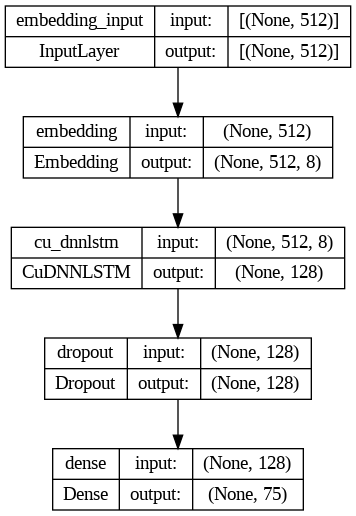

In [ ]:
plot_model(model_lstm1, show_shapes = True) #, to_file = '/content/drive/MyDrive/Colab Notebooks/protein_seq_classification/pdb/pdb_lstm1.png')

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                                                  mode= 'min',
                                                  restore_best_weights=False,
                                                  patience=3)

In [ ]:
history_lstm1 = model_lstm1.fit(X_train_512, y_train_512, batch_size=32, epochs=30, validation_data=(X_val_512, y_val_512), callbacks = early_stopping)


Epoch 1/30
3111/3111 [==============================] - 86s 24ms/step - loss: 3.2298 - accuracy: 0.1776 - val_loss: 3.1092 - val_accuracy: 0.1702
Epoch 2/30
3111/3111 [==============================] - 62s 20ms/step - loss: 3.0843 - accuracy: 0.1873 - val_loss: 3.0373 - val_accuracy: 0.1940
Epoch 3/30
3111/3111 [==============================] - 62s 20ms/step - loss: 3.0436 - accuracy: 0.1959 - val_loss: 2.9870 - val_accuracy: 0.2106
Epoch 4/30
3111/3111 [==============================] - 67s 22ms/step - loss: 2.9919 - accuracy: 0.2089 - val_loss: 2.9703 - val_accuracy: 0.2174
Epoch 5/30
3111/3111 [==============================] - 67s 22ms/step - loss: 2.9470 - accuracy: 0.2211 - val_loss: 2.9245 - val_accuracy: 0.2179
Epoch 6/30
3111/3111 [==============================] - 64s 21ms/step - loss: 2.9044 - accuracy: 0.2324 - val_loss: 2.8411 - val_accuracy: 0.2475
Epoch 7/30
3111/3111 [==============================] - 89s 28ms/step - loss: 2.8345 - accuracy: 0.2492 - val_loss: 2.7876 -

In [ ]:
# convert the history.history dict to a pandas DataFrame:
# histlstm1_df = pd.DataFrame(history_lstm1.history)
# histlstm1_df.to_csv('hist_lstm1.csv', index = False)

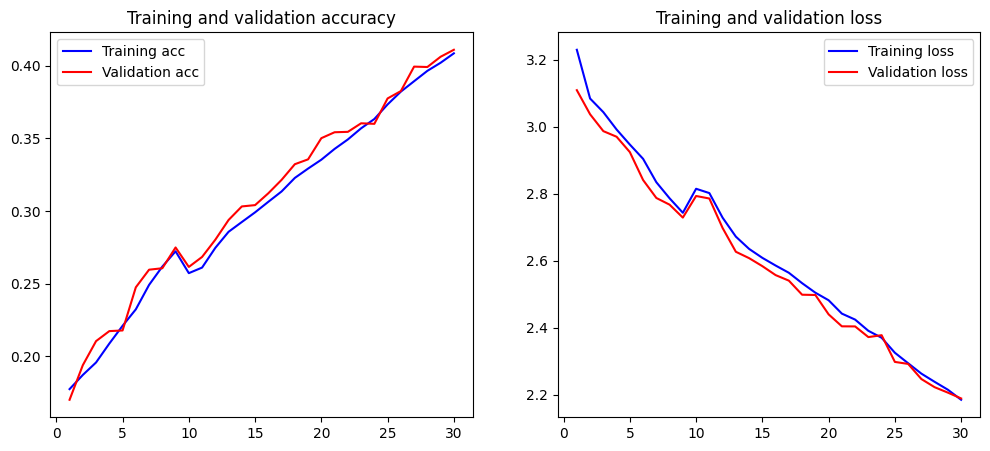

In [ ]:
plot_history(history_lstm1)

In [ ]:
test_loss, test_acc = model_lstm1.evaluate(X_test_512, y_test_512, verbose=1)
print("Test Accuracy: ",test_acc)
print("Test Loss: ",test_loss)

865/865 [==============================] - 13s 15ms/step - loss: 2.1952 - accuracy: 0.4070
Test Accuracy:  0.4070082902908325
Test Loss:  2.195152521133423


In [ ]:
train_pred_lstm1 = model_lstm1.predict(X_train_512)
test_pred_lstm1 = model_lstm1.predict(X_test_512)
print("train-acc = " + str(accuracy_score(np.argmax(train_pred_lstm1, axis=1), np.argmax(y_train_512, axis=1))))
print("test-acc = " + str(accuracy_score(np.argmax(test_pred_lstm1, axis=1), np.argmax(y_test_512, axis=1))))
print("test f1-score = " + str(f1_score(np.argmax(y_test_512, axis=1), np.argmax(test_pred_lstm1, axis=1), average = 'weighted')))

865/865 [==============================] - 6s 7ms/step
train-acc = 0.4206857062493094
test-acc = 0.40700828119914656
test f1-score = 0.3630572215830823


In [ ]:
print(classification_report(np.argmax(y_test_512, axis=1), np.argmax(test_pred_lstm1, axis=1), target_names=lb.classes_))

                          precision    recall  f1-score   support

                allergen       0.00      0.00      0.00        28
    antibiotic hydrolase       0.00      0.00      0.00        26
  antibiotic transferase       0.00      0.00      0.00        20
   antimicrobial protein       0.00      0.00      0.00        37
               apoptosis       0.00      0.00      0.00       107
    biosynthetic protein       0.00      0.00      0.00        83
  biotin-binding protein       0.60      0.50      0.55        24
          blood clotting       0.00      0.00      0.00        67
 calcium-binding protein       0.06      0.04      0.05        24
           cell adhesion       0.14      0.00      0.01       287
              cell cycle       0.34      0.15      0.20       234
           cell invasion       0.00      0.00      0.00        21
               chaperone       0.73      0.29      0.41       268
     contractile protein       0.76      0.16      0.27        79
         

#### EXPERIMENT 2

In [ ]:
embedding_dim = 8
top_classes = 75
max_length = 256

model_lstm2 = Sequential()
model_lstm2.add(Embedding(len(tokenizer.word_index)+1, 8, input_length=max_length))
model_lstm2.add(CuDNNLSTM(128))
# model_lstm2.add(LSTM(128, dropout = 0.2, recurrent_dropout=0.2)) # (CuDNNLSTM(128)) if CuDNNLSTM not available
model_lstm2.add(Dropout(0.2))
model_lstm2.add(Dense(top_classes,activation='softmax'))
model_lstm2.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics = ['accuracy'])
print(model_lstm2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 256, 8)            168       
                                                                 
 cu_dnnlstm_1 (CuDNNLSTM)    (None, 128)               70656     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 75)                9675      
                                                                 
Total params: 80499 (314.45 KB)
Trainable params: 80499 (314.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


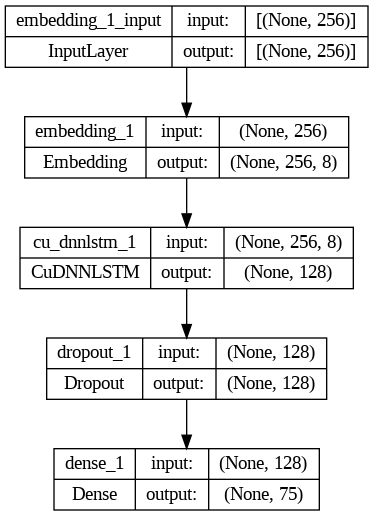

In [ ]:
plot_model(model_lstm2, show_shapes = True) #, to_file = '/content/drive/MyDrive/Colab Notebooks/protein_seq_classification/pdb/pdb_lstm2.png')

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                                                  mode= 'min',
                                                  restore_best_weights=False,
                                                  patience=3)

In [ ]:
history_lstm2 = model_lstm2.fit(X_train_256, y_train_256, batch_size=32, epochs=30, validation_data=(X_val_256, y_val_256), callbacks = early_stopping)

Epoch 1/30
3111/3111 [==============================] - 42s 13ms/step - loss: 3.1444 - accuracy: 0.1803 - val_loss: 3.0804 - val_accuracy: 0.1898
Epoch 2/30
3111/3111 [==============================] - 39s 13ms/step - loss: 3.0956 - accuracy: 0.1873 - val_loss: 3.0547 - val_accuracy: 0.1887
Epoch 3/30
3111/3111 [==============================] - 40s 13ms/step - loss: 3.0369 - accuracy: 0.2011 - val_loss: 3.0184 - val_accuracy: 0.2014
Epoch 4/30
3111/3111 [==============================] - 38s 12ms/step - loss: 3.0583 - accuracy: 0.1953 - val_loss: 3.0237 - val_accuracy: 0.1979
Epoch 5/30
3111/3111 [==============================] - 39s 12ms/step - loss: 3.0080 - accuracy: 0.2080 - val_loss: 2.9339 - val_accuracy: 0.2223
Epoch 6/30
3111/3111 [==============================] - 40s 13ms/step - loss: 2.9834 - accuracy: 0.2165 - val_loss: 2.8793 - val_accuracy: 0.2379
Epoch 7/30
3111/3111 [==============================] - 39s 13ms/step - loss: 2.8531 - accuracy: 0.2487 - val_loss: 2.7815 -

In [ ]:
# convert the history.history dict to a pandas DataFrame:
# histlstm2_df = pd.DataFrame(history_lstm2.history)
# histlstm2_df.to_csv('hist_lstm2.csv', index = False)

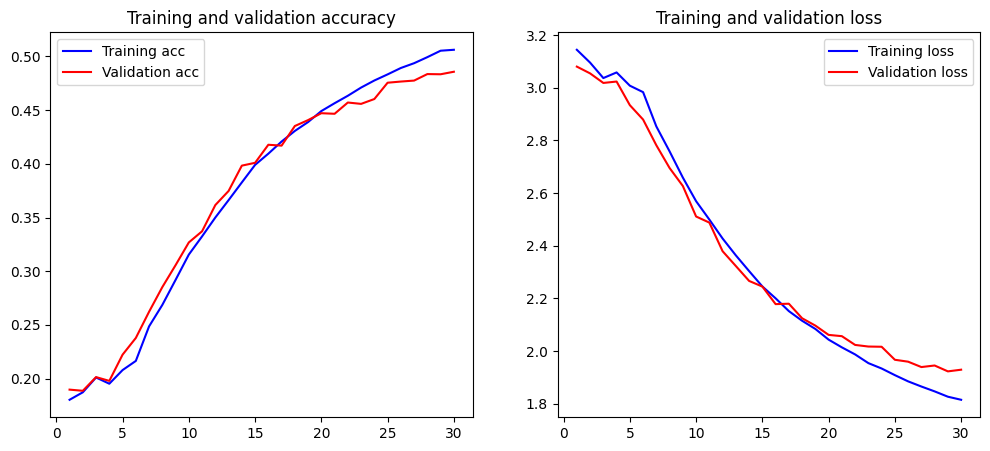

In [ ]:
plot_history(history_lstm2)

In [ ]:
test_loss2, test_acc2 = model_lstm2.evaluate(X_test_256, y_test_256, verbose=1)
print("Test Accuracy: ",test_acc2)
print("Test Loss: ",test_loss2)

865/865 [==============================] - 11s 12ms/step - loss: 1.9230 - accuracy: 0.4884
Test Accuracy:  0.48844608664512634
Test Loss:  1.9230401515960693


In [ ]:
train_pred_lstm2 = model_lstm2.predict(X_train_256)
test_pred_lstm2 = model_lstm2.predict(X_test_256)
print("train-acc = " + str(accuracy_score(np.argmax(train_pred_lstm2, axis=1), np.argmax(y_train_256, axis=1))))
print("test-acc = " + str(accuracy_score(np.argmax(test_pred_lstm2, axis=1), np.argmax(y_test_256, axis=1))))
print("test f1-score = " + str(f1_score(np.argmax(y_test_256, axis=1), np.argmax(test_pred_lstm2, axis=1), average = 'weighted')))

865/865 [==============================] - 6s 7ms/step
train-acc = 0.5276603011642742
test-acc = 0.48844609988066395
test f1-score = 0.45761119266896205


In [ ]:
print(classification_report(np.argmax(y_test_256, axis=1), np.argmax(test_pred_lstm2, axis=1), target_names=lb.classes_))

                          precision    recall  f1-score   support

                allergen       1.00      0.21      0.35        28
    antibiotic hydrolase       1.00      0.08      0.14        26
  antibiotic transferase       1.00      0.05      0.10        20
   antimicrobial protein       0.00      0.00      0.00        37
               apoptosis       0.53      0.22      0.32       107
    biosynthetic protein       0.00      0.00      0.00        83
  biotin-binding protein       0.66      0.79      0.72        24
          blood clotting       0.77      0.15      0.25        67
 calcium-binding protein       1.00      0.08      0.15        24
           cell adhesion       0.20      0.06      0.10       287
              cell cycle       0.37      0.20      0.26       234
           cell invasion       1.00      0.10      0.17        21
               chaperone       0.49      0.35      0.41       268
     contractile protein       0.55      0.37      0.44        79
         

#### EXPERIMENT 3

In [ ]:
embedding_dim = 8
top_classes = 75
max_length = 100

model_lstm3 = Sequential()
model_lstm3.add(Embedding(len(tokenizer.word_index)+1, 8, input_length=max_length))
model_lstm3.add(CuDNNLSTM(128))
# model_lstm3.add(LSTM(128, dropout = 0.2, recurrent_dropout=0.2)) # (CuDNNLSTM(128)) if CuDNNLSTM not available
model_lstm3.add(Dropout(0.2))
model_lstm3.add(Dense(top_classes,activation='softmax'))
model_lstm3.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics = ['accuracy'])
print(model_lstm3.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 8)            168       
                                                                 
 cu_dnnlstm_2 (CuDNNLSTM)    (None, 128)               70656     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 75)                9675      
                                                                 
Total params: 80499 (314.45 KB)
Trainable params: 80499 (314.45 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None


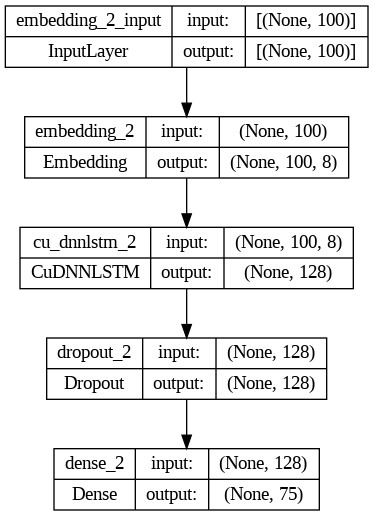

In [ ]:
plot_model(model_lstm3, show_shapes = True) #, to_file = '/content/drive/MyDrive/Colab Notebooks/protein_seq_classification/pdb/pdb_lstm2.png')

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                                                  mode= 'min',
                                                  restore_best_weights=False,
                                                  patience=3)

# usage
metrics_callback = MetricsCallback(validation_data=(X_val_100, y_val_100))

In [ ]:
history_lstm3 = model_lstm3.fit(X_train_100, y_train_100, batch_size=32, epochs=30, validation_data=(X_val_100, y_val_100), callbacks = [metrics_callback, early_stopping])

Epoch 1/30
3111/3111 [==============================] - 28s 8ms/step - loss: 3.1826 - accuracy: 0.1873 - val_loss: 3.0450 - val_accuracy: 0.2161
Epoch 2/30
3111/3111 [==============================] - 25s 8ms/step - loss: 2.9781 - accuracy: 0.2243 - val_loss: 2.9007 - val_accuracy: 0.2330
Epoch 3/30
3111/3111 [==============================] - 26s 8ms/step - loss: 2.8290 - accuracy: 0.2570 - val_loss: 2.7424 - val_accuracy: 0.2734
Epoch 4/30
3111/3111 [==============================] - 27s 9ms/step - loss: 2.6933 - accuracy: 0.2941 - val_loss: 2.6125 - val_accuracy: 0.3098
Epoch 5/30
3111/3111 [==============================] - 25s 8ms/step - loss: 2.5714 - accuracy: 0.3234 - val_loss: 2.5223 - val_accuracy: 0.3353
Epoch 6/30
3111/3111 [==============================] - 27s 9ms/step - loss: 2.4692 - accuracy: 0.3477 - val_loss: 2.4240 - val_accuracy: 0.3536
Epoch 7/30
3111/3111 [==============================] - 47s 15ms/step - loss: 2.3798 - accuracy: 0.3708 - val_loss: 2.3528 - val_a

In [ ]:
# Calculate mean and standard deviation for accuracy and loss across epochs
mean_accuracy = np.mean(metrics_callback.epoch_accuracy)
std_accuracy = np.std(metrics_callback.epoch_accuracy)
mean_loss = np.mean(metrics_callback.epoch_loss)
std_loss = np.std(metrics_callback.epoch_loss)

mean_val_accuracy = np.mean(metrics_callback.epoch_val_accuracy)
std_val_accuracy = np.std(metrics_callback.epoch_val_accuracy)
mean_val_loss = np.mean(metrics_callback.epoch_val_loss)
std_val_loss = np.std(metrics_callback.epoch_val_loss)

mean_f1_weighted = np.mean(metrics_callback.epoch_f1_weighted)
std_f1_weighted = np.std(metrics_callback.epoch_f1_weighted)
mean_f1_macro = np.mean(metrics_callback.epoch_f1_macro)
std_f1_macro = np.std(metrics_callback.epoch_f1_macro)

print(f"Training Accuracy (mean ± std): {mean_accuracy:.3f} ± {std_accuracy:.3f}")
print(f"Training Loss (mean ± std): {mean_loss:.3f} ± {std_loss:.3f}")
print(f"Validation Accuracy (mean ± std): {mean_val_accuracy:.3f} ± {std_val_accuracy:.3f}")
print(f"Validation Loss (mean ± std): {mean_val_loss:.3f} ± {std_val_loss:.3f}")
print(f"Validation F1 Score (weighted) (mean ± std): {mean_f1_weighted:.3f} ± {std_f1_weighted:.3f}")
print(f"Validation F1 Score (macro) (mean ± std): {mean_f1_macro:.3f} ± {std_f1_macro:.3f}")

Training Accuracy (mean ± std): 0.442 ± 0.098
Training Loss (mean ± std): 2.104 ± 0.397
Validation Accuracy (mean ± std): 0.431 ± 0.082
Validation Loss (mean ± std): 2.182 ± 0.300
Validation F1 Score (weighted) (mean ± std): 0.424 ± 0.197
Validation F1 Score (macro) (mean ± std): 0.310 ± 0.202


In [ ]:
# Lists to store the training and validation loss and accuracy
train_acc = history_lstm3.history['accuracy']
train_loss = history_lstm3.history['loss']

val_acc = history_lstm3.history['val_accuracy']
val_loss = history_lstm3.history['val_loss']

mean_accuracy = np.mean(train_acc)
std_accuracy = np.std(train_acc)
mean_loss = np.mean(train_loss)
std_loss = np.std(train_loss)
mean_val_accuracy = np.mean(val_acc)
std_val_accuracy = np.std(val_acc)
mean_val_loss = np.mean(val_loss)
std_val_loss = np.std(val_loss)

print(f"Training Accuracy (mean ± std): {mean_accuracy:.3f} ± {std_accuracy:.3f}")
print(f"Training Loss (mean ± std): {mean_loss:.3f} ± {std_loss:.3f}")
print(f"Validation Accuracy (mean ± std): {mean_val_accuracy:.3f} ± {std_val_accuracy:.3f}")
print(f"Validation Loss (mean ± std): {mean_val_loss:.3f} ± {std_val_loss:.3f}")

Training Accuracy (mean ± std): 0.442 ± 0.098
Training Loss (mean ± std): 2.104 ± 0.397
Validation Accuracy (mean ± std): 0.431 ± 0.082
Validation Loss (mean ± std): 2.182 ± 0.300


In [ ]:
# convert the history.history dict to a pandas DataFrame:
# histlstm3_df = pd.DataFrame(history_lstm3.history)
# histlstm3_df.to_csv('hist_lstm3.csv', index = False)

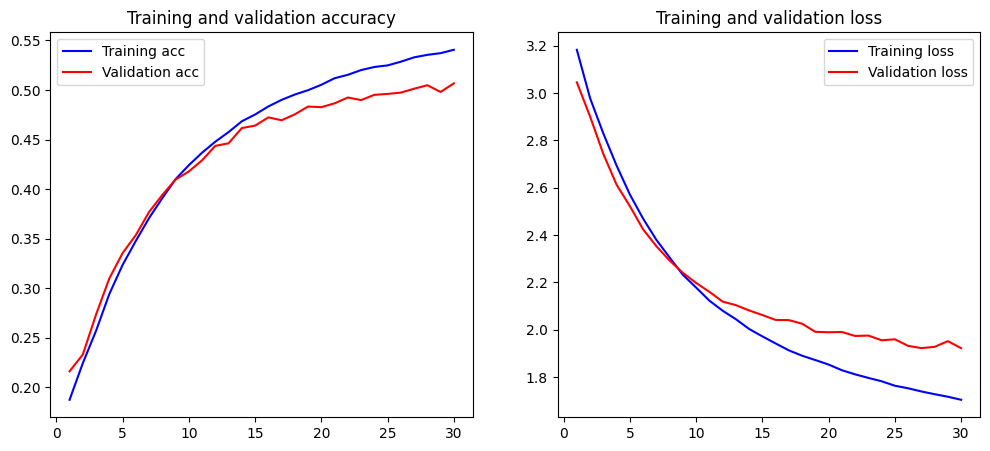

In [ ]:
plot_history(history_lstm3)

In [ ]:
test_loss3, test_acc3 = model_lstm3.evaluate(X_test_100, y_test_100, verbose=1)
print("Test Accuracy: ",test_acc3)
print("Test Loss: ",test_loss3)

865/865 [==============================] - 7s 8ms/step - loss: 1.9236 - accuracy: 0.5059
Test Accuracy:  0.5058764219284058
Test Loss:  1.9235647916793823


In [ ]:
train_pred_lstm3 = model_lstm3.predict(X_train_100)
test_pred_lstm3 = model_lstm3.predict(X_test_100)
print("train-acc = " + str(accuracy_score(np.argmax(train_pred_lstm3, axis=1), np.argmax(y_train_100, axis=1))))
print("test-acc = " + str(accuracy_score(np.argmax(test_pred_lstm3, axis=1), np.argmax(y_test_100, axis=1))))
print("test f1-score = " + str(f1_score(np.argmax(y_test_100, axis=1), np.argmax(test_pred_lstm3, axis=1), average = 'weighted')))

865/865 [==============================] - 5s 5ms/step
train-acc = 0.568605784202437
test-acc = 0.5058763967743102
test f1-score = 0.4765535942985635


In [ ]:
print(classification_report(np.argmax(y_test_100, axis=1), np.argmax(test_pred_lstm3, axis=1), target_names=lb.classes_))

                          precision    recall  f1-score   support

                allergen       1.00      0.18      0.30        28
    antibiotic hydrolase       0.00      0.00      0.00        26
  antibiotic transferase       0.67      0.10      0.17        20
   antimicrobial protein       0.50      0.03      0.05        37
               apoptosis       0.77      0.19      0.30       107
    biosynthetic protein       0.40      0.07      0.12        83
  biotin-binding protein       0.68      0.71      0.69        24
          blood clotting       0.65      0.22      0.33        67
 calcium-binding protein       0.12      0.08      0.10        24
           cell adhesion       0.40      0.17      0.24       287
              cell cycle       0.41      0.19      0.26       234
           cell invasion       1.00      0.10      0.17        21
               chaperone       0.55      0.40      0.46       268
     contractile protein       0.56      0.48      0.52        79
         

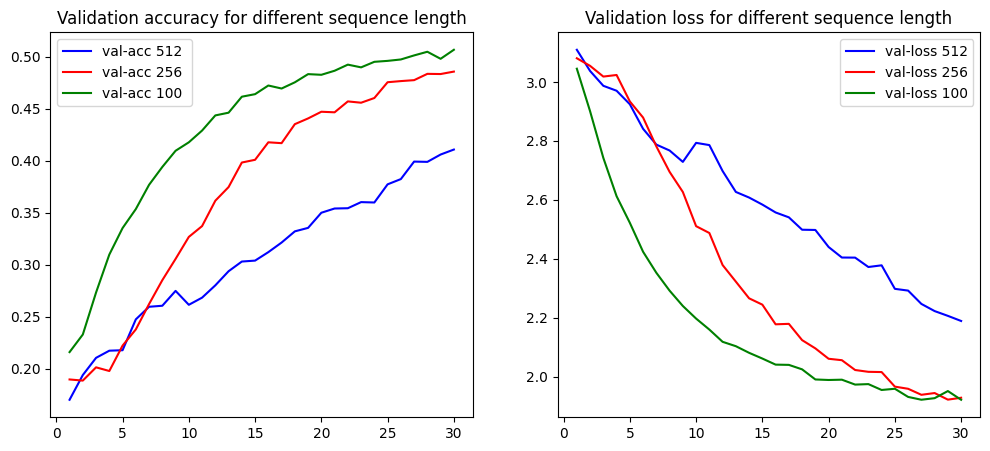

In [ ]:
plot_compare_history(history_lstm1, history_lstm2, history_lstm3)

### Multichannel CNN1D

##### EXPERIMENT 1

In [ ]:
# define model
def define_model(vocab_size,embedding_dim, channels,  filter_size, kernel_size, length, total_classes):
    inputs = {}
    embedding = {}
    conv = {}
    drop = {}
    pool = {}
    flat = {}
    for channel in range(1, channels + 1):
        inputs[channel] = Input(shape = (length,), dtype ='float64')
        embedding[channel] = Embedding(vocab_size, embedding_dim, input_length = length)(inputs[channel])
        conv[channel] = Conv1D(filters=filter_size[channel], kernel_size=kernel_size[channel], activation = 'relu')(embedding[channel])
        drop[channel] = Dropout(0.2)(conv[channel])
        pool[channel] = MaxPooling1D(pool_size = 2)(drop[channel])
        flat[channel] = Flatten()(pool[channel])
    merged = concatenate(list(flat.values()))
    dense = Dense(1120, activation = 'relu')(merged)
    outputs = Dense(total_classes, activation = 'softmax')(dense)       # softmax for multiclass classification

    model = Model(list(inputs.values()), outputs=outputs)

    model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

    print(model.summary())
    # plot_model(model, show_shapes = True, to_file = 'multichannel.png')
    return model




In [ ]:
vocab_size = len(tokenizer.word_index)+1
embedding_dim = 8
top_classes = 75
max_length = 512

combine_model1 = define_model(vocab_size, 8, 3, {1:128, 2:64, 3:32}, {1 : 12, 2 : 6, 3 : 3}, max_length, top_classes)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 512)]                0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 512)]                0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, 512)]                0         []                            
                                                                                                  
 embedding_3 (Embedding)     (None, 512, 8)               168       ['input_1[0][0]']             
                                                                                              

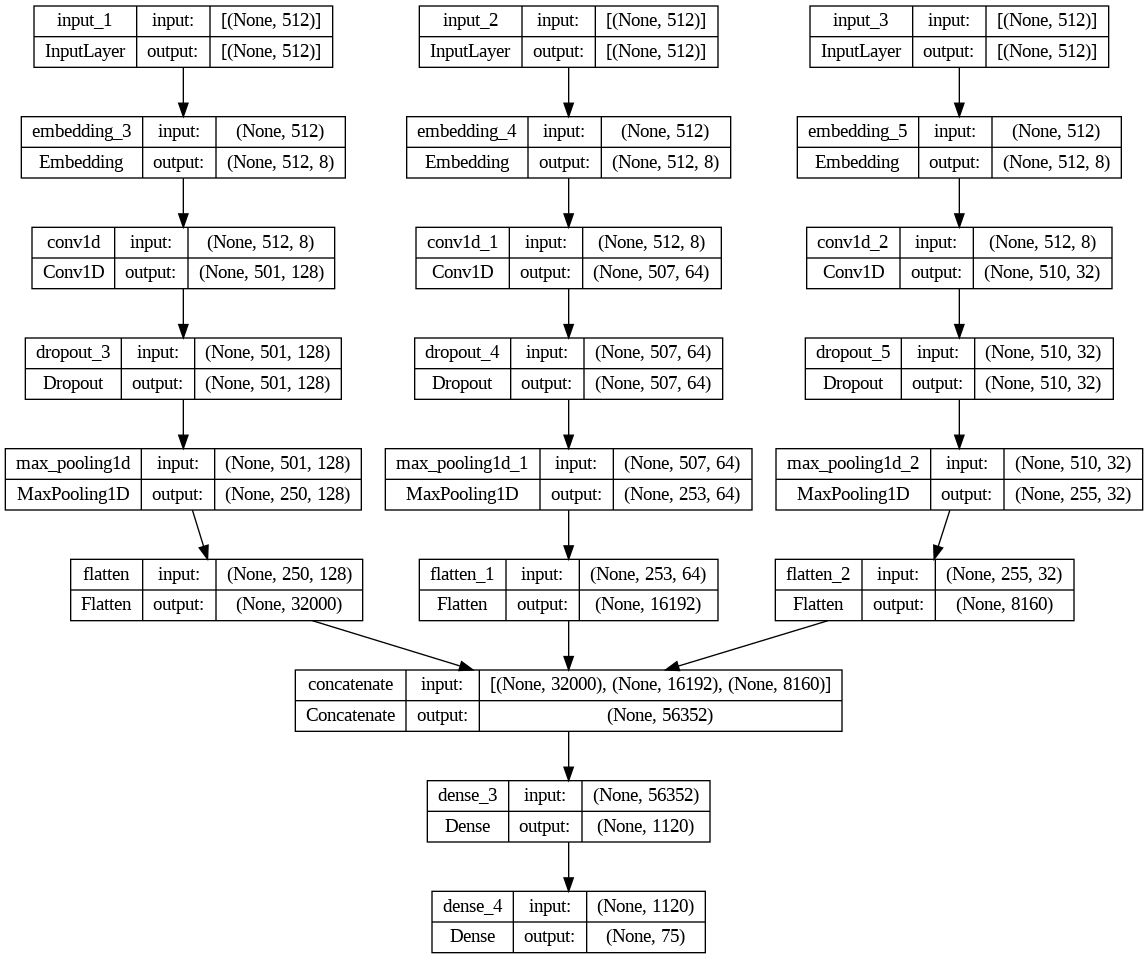

In [ ]:
plot_model(combine_model1, show_shapes = True) #, to_file = '/content/drive/MyDrive/Colab Notebooks/protein_seq_classification/pdb/multichannel.png')

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                                                  mode= 'min',
                                                  restore_best_weights=False,
                                                  patience=3)

metrics_callback_cnn = MetricsCallback(validation_data=([X_val_512, X_val_512, X_val_512], y_val_512))

In [ ]:
history_combine_model1 = combine_model1.fit([X_train_512, X_train_512, X_train_512], y_train_512, epochs = 20, batch_size = 128, validation_data=([X_val_512, X_val_512, X_val_512], y_val_512), callbacks = [metrics_callback_cnn, early_stopping], verbose = 1)

Epoch 1/20
778/778 [==============================] - 364s 466ms/step - loss: 2.1029 - accuracy: 0.4574 - val_loss: 1.6148 - val_accuracy: 0.5707
Epoch 2/20
778/778 [==============================] - 289s 371ms/step - loss: 1.1742 - accuracy: 0.6736 - val_loss: 1.4060 - val_accuracy: 0.6374
Epoch 3/20
778/778 [==============================] - 281s 362ms/step - loss: 0.7306 - accuracy: 0.7873 - val_loss: 1.4328 - val_accuracy: 0.6614
Epoch 4/20
778/778 [==============================] - 279s 358ms/step - loss: 0.5348 - accuracy: 0.8430 - val_loss: 1.4629 - val_accuracy: 0.6653
Epoch 5/20
778/778 [==============================] - 281s 362ms/step - loss: 0.4465 - accuracy: 0.8674 - val_loss: 1.4865 - val_accuracy: 0.6648


In [ ]:
# Calculate mean and standard deviation for accuracy and loss across epochs
mean_accuracy = np.mean(metrics_callback_cnn.epoch_accuracy)
std_accuracy = np.std(metrics_callback_cnn.epoch_accuracy)
mean_loss = np.mean(metrics_callback_cnn.epoch_loss)
std_loss = np.std(metrics_callback_cnn.epoch_loss)

mean_val_accuracy = np.mean(metrics_callback_cnn.epoch_val_accuracy)
std_val_accuracy = np.std(metrics_callback_cnn.epoch_val_accuracy)
mean_val_loss = np.mean(metrics_callback_cnn.epoch_val_loss)
std_val_loss = np.std(metrics_callback_cnn.epoch_val_loss)

mean_f1_weighted = np.mean(metrics_callback_cnn.epoch_f1_weighted)
std_f1_weighted = np.std(metrics_callback_cnn.epoch_f1_weighted)
mean_f1_macro = np.mean(metrics_callback_cnn.epoch_f1_macro)
std_f1_macro = np.std(metrics_callback_cnn.epoch_f1_macro)

print(f"Training Accuracy (mean ± std): {mean_accuracy:.3f} ± {std_accuracy:.3f}")
print(f"Training Loss (mean ± std): {mean_loss:.3f} ± {std_loss:.3f}")
print(f"Validation Accuracy (mean ± std): {mean_val_accuracy:.3f} ± {std_val_accuracy:.3f}")
print(f"Validation Loss (mean ± std): {mean_val_loss:.3f} ± {std_val_loss:.3f}")
print(f"Validation F1 Score (weighted) (mean ± std): {mean_f1_weighted:.3f} ± {std_f1_weighted:.3f}")
print(f"Validation F1 Score (macro) (mean ± std): {mean_f1_macro:.3f} ± {std_f1_macro:.3f}")

Training Accuracy (mean ± std): 0.726 ± 0.150
Training Loss (mean ± std): 0.998 ± 0.607
Validation Accuracy (mean ± std): 0.640 ± 0.036
Validation Loss (mean ± std): 1.481 ± 0.072
Validation F1 Score (weighted) (mean ± std): 0.632 ± 0.037
Validation F1 Score (macro) (mean ± std): 0.509 ± 0.068


In [ ]:
train_acc = history_combine_model1.history['accuracy']
train_loss = history_combine_model1.history['loss']

val_acc = history_combine_model1.history['val_accuracy']
val_loss = history_combine_model1.history['val_loss']

mean_accuracy = np.mean(train_acc)
std_accuracy = np.std(train_acc)
mean_loss = np.mean(train_loss)
std_loss = np.std(train_loss)
mean_val_accuracy = np.mean(val_acc)
std_val_accuracy = np.std(val_acc)
mean_val_loss = np.mean(val_loss)
std_val_loss = np.std(val_loss)

print(f"Training Accuracy (mean ± std): {mean_accuracy:.3f} ± {std_accuracy:.3f}")
print(f"Training Loss (mean ± std): {mean_loss:.3f} ± {std_loss:.3f}")
print(f"Validation Accuracy (mean ± std): {mean_val_accuracy:.3f} ± {std_val_accuracy:.3f}")
print(f"Validation Loss (mean ± std): {mean_val_loss:.3f} ± {std_val_loss:.3f}")

Training Accuracy (mean ± std): 0.726 ± 0.150
Training Loss (mean ± std): 0.998 ± 0.607
Validation Accuracy (mean ± std): 0.640 ± 0.036
Validation Loss (mean ± std): 1.481 ± 0.072


In [ ]:
# convert the history.history dict to a pandas DataFrame:
# histcnn1_df = pd.DataFrame(history_combine_model1.history)
# histcnn1_df.to_csv('hist_cnn1.csv', index = False)

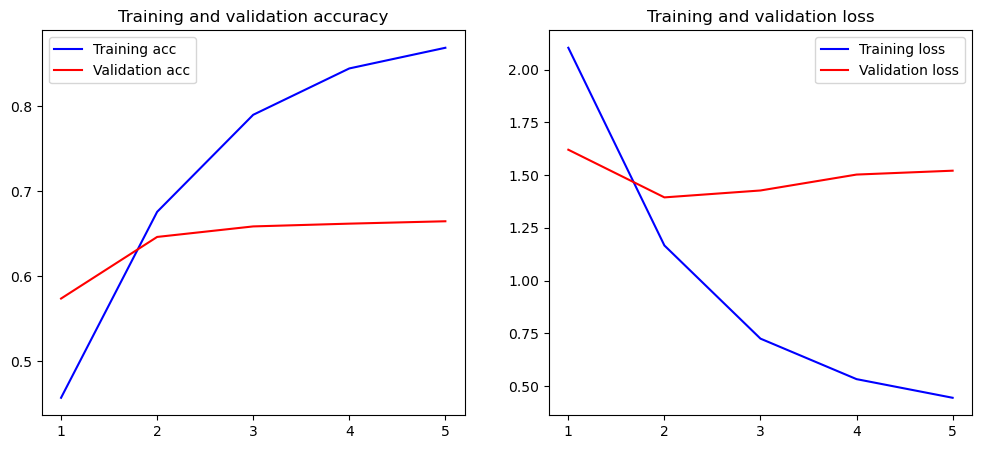

In [ ]:
plot_history(history_combine_model1)

In [ ]:
test_loss, test_acc = combine_model1.evaluate([X_test_512, X_test_512, X_test_512],y_test_512, verbose=1)
print("Test Accuracy: ",test_acc)
print("Test Loss: ",test_loss)

865/865 [==============================] - 19s 22ms/step - loss: 1.5037 - accuracy: 0.6646
Test Accuracy:  0.6646295189857483
Test Loss:  1.5037003755569458


In [ ]:
train_pred_combine1 = combine_model1.predict([X_train_512, X_train_512, X_train_512])
test_pred_combine1 = combine_model1.predict([X_test_512, X_test_512, X_test_512])
print("train-acc = " + str(accuracy_score(np.argmax(train_pred_combine1, axis=1), np.argmax(y_train_512, axis=1))))
print("test-acc = " + str(accuracy_score(np.argmax(test_pred_combine1, axis=1), np.argmax(y_test_512, axis=1))))
print("test f1-score = " + str(f1_score(np.argmax(y_test_512, axis=1), np.argmax(test_pred_combine1, axis=1), average = 'weighted')))

865/865 [==============================] - 21s 24ms/step
train-acc = 0.8947130501170302
test-acc = 0.6646295157849058
test f1-score = 0.6594040136987906


In [ ]:
print(classification_report(np.argmax(y_test_512, axis=1), np.argmax(test_pred_combine1, axis=1), target_names=lb.classes_))

                          precision    recall  f1-score   support

                allergen       0.86      0.68      0.76        28
    antibiotic hydrolase       0.41      0.27      0.33        26
  antibiotic transferase       0.41      0.35      0.38        20
   antimicrobial protein       0.49      0.46      0.47        37
               apoptosis       0.86      0.50      0.64       107
    biosynthetic protein       0.50      0.45      0.47        83
  biotin-binding protein       0.83      0.79      0.81        24
          blood clotting       0.79      0.28      0.42        67
 calcium-binding protein       0.19      0.29      0.23        24
           cell adhesion       0.72      0.47      0.57       287
              cell cycle       0.62      0.46      0.53       234
           cell invasion       0.78      0.33      0.47        21
               chaperone       0.78      0.59      0.67       268
     contractile protein       0.83      0.48      0.61        79
         

In [ ]:
# save classification report
# cnn1_report = classification_report(np.argmax(y_test_512, axis=1), np.argmax(test_pred_combine1, axis=1), target_names=lb.classes_, output_dict=True)
# cnn1_report.update({"accuracy": {"precision": None, "recall": None, "f1-score": cnn1_report["accuracy"], "support": cnn1_report['macro avg']['support']}})

# cnn1_df = pd.DataFrame(cnn1_report).transpose()
# cnn1_df.to_csv('cnn1_report.csv', index = False)

##### Experiment 1a with class weight

In [ ]:
vocab_size = len(tokenizer.word_index)+1
embedding_dim = 8
top_classes = 75
max_length = 512

model_cnn1a = define_model(vocab_size, 8, 3, {1:128, 2:64, 3:32}, {1 : 12, 2 : 6, 3 : 3}, max_length, top_classes)

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 512)]        0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 512)]        0           []                               
                                                                                                  
 input_15 (InputLayer)          [(None, 512)]        0           []                               
                                                                                                  
 embedding_12 (Embedding)       (None, 512, 8)       168         ['input_13[0][0]']               
                                                                                            

In [ ]:
metrics_callback_cnn1a = MetricsCallback(validation_data=([X_val_512, X_val_512, X_val_512], y_val_512))

In [ ]:
history_cnn1a = model_cnn1a.fit([X_train_512, X_train_512, X_train_512], y_train_512, validation_data=([X_val_512, X_val_512, X_val_512], y_val_512), epochs=20, batch_size=128, class_weight = class_weight_dict, callbacks = [metrics_callback_cnn1a, early_stopping])


Epoch 1/20
778/778 [==============================] - 223s 284ms/step - loss: 2.9824 - accuracy: 0.2078 - val_loss: 2.5460 - val_accuracy: 0.3662
Epoch 2/20
778/778 [==============================] - 179s 230ms/step - loss: 1.4243 - accuracy: 0.4558 - val_loss: 2.1781 - val_accuracy: 0.4563
Epoch 3/20
778/778 [==============================] - 182s 234ms/step - loss: 0.8368 - accuracy: 0.6059 - val_loss: 1.9182 - val_accuracy: 0.5273
Epoch 4/20
778/778 [==============================] - 179s 230ms/step - loss: 0.6162 - accuracy: 0.6942 - val_loss: 1.8314 - val_accuracy: 0.5532
Epoch 5/20
778/778 [==============================] - 187s 240ms/step - loss: 0.5017 - accuracy: 0.7448 - val_loss: 1.8673 - val_accuracy: 0.5782
Epoch 6/20
778/778 [==============================] - 180s 231ms/step - loss: 0.4561 - accuracy: 0.7762 - val_loss: 1.7595 - val_accuracy: 0.5977
Epoch 7/20
778/778 [==============================] - 183s 235ms/step - loss: 0.4142 - accuracy: 0.7951 - val_loss: 1.8132 -

In [ ]:
# Calculate mean and standard deviation for accuracy and loss across epochs
mean_accuracy = np.mean(metrics_callback_cnn1a.epoch_accuracy)
std_accuracy = np.std(metrics_callback_cnn1a.epoch_accuracy)
mean_loss = np.mean(metrics_callback_cnn1a.epoch_loss)
std_loss = np.std(metrics_callback_cnn1a.epoch_loss)

mean_val_accuracy = np.mean(metrics_callback_cnn1a.epoch_val_accuracy)
std_val_accuracy = np.std(metrics_callback_cnn1a.epoch_val_accuracy)
mean_val_loss = np.mean(metrics_callback_cnn1a.epoch_val_loss)
std_val_loss = np.std(metrics_callback_cnn1a.epoch_val_loss)

mean_f1_weighted = np.mean(metrics_callback_cnn1a.epoch_f1_weighted)
std_f1_weighted = np.std(metrics_callback_cnn1a.epoch_f1_weighted)
mean_f1_macro = np.mean(metrics_callback_cnn1a.epoch_f1_macro)
std_f1_macro = np.std(metrics_callback_cnn1a.epoch_f1_macro)

print(f"Training Accuracy (mean ± std): {mean_accuracy:.3f} ± {std_accuracy:.3f}")
print(f"Training Loss (mean ± std): {mean_loss:.3f} ± {std_loss:.3f}")
print(f"Validation Accuracy (mean ± std): {mean_val_accuracy:.3f} ± {std_val_accuracy:.3f}")
print(f"Validation Loss (mean ± std): {mean_val_loss:.3f} ± {std_val_loss:.3f}")
print(f"Validation F1 Score (weighted) (mean ± std): {mean_f1_weighted:.3f} ± {std_f1_weighted:.3f}")
print(f"Validation F1 Score (macro) (mean ± std): {mean_f1_macro:.3f} ± {std_f1_macro:.3f}")

Training Accuracy (mean ± std): 0.722 ± 0.177
Training Loss (mean ± std): 0.682 ± 0.690
Validation Accuracy (mean ± std): 0.567 ± 0.070
Validation Loss (mean ± std): 1.860 ± 0.219
Validation F1 Score (weighted) (mean ± std): 0.581 ± 0.066
Validation F1 Score (macro) (mean ± std): 0.495 ± 0.056


In [ ]:
train_acc = history_cnn1a.history['accuracy']
train_loss = history_cnn1a.history['loss']

val_acc = history_cnn1a.history['val_accuracy']
val_loss = history_cnn1a.history['val_loss']

mean_accuracy = np.mean(train_acc)
std_accuracy = np.std(train_acc)
mean_loss = np.mean(train_loss)
std_loss = np.std(train_loss)
mean_val_accuracy = np.mean(val_acc)
std_val_accuracy = np.std(val_acc)
mean_val_loss = np.mean(val_loss)
std_val_loss = np.std(val_loss)

print(f"Training Accuracy (mean ± std): {mean_accuracy:.3f} ± {std_accuracy:.3f}")
print(f"Training Loss (mean ± std): {mean_loss:.3f} ± {std_loss:.3f}")
print(f"Validation Accuracy (mean ± std): {mean_val_accuracy:.3f} ± {std_val_accuracy:.3f}")
print(f"Validation Loss (mean ± std): {mean_val_loss:.3f} ± {std_val_loss:.3f}")

Training Accuracy (mean ± std): 0.722 ± 0.177
Training Loss (mean ± std): 0.682 ± 0.690
Validation Accuracy (mean ± std): 0.567 ± 0.070
Validation Loss (mean ± std): 1.860 ± 0.219


In [ ]:
# convert the history.history dict to a pandas DataFrame:
# histcnn1a_df = pd.DataFrame(history_cnn1a.history)
# histcnn1a_df.to_csv('hist_cnn1a.csv', index = False)

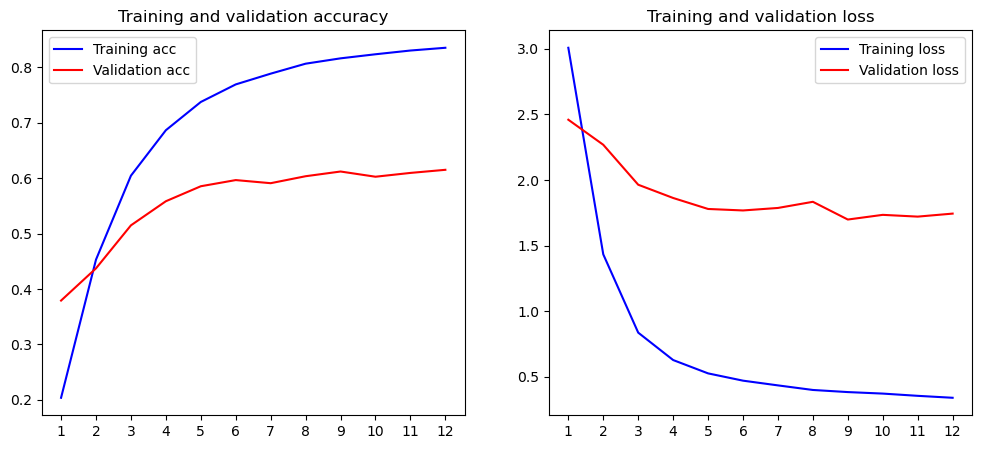

In [ ]:
plot_history(history_cnn1a)

In [ ]:
test_loss, test_acc = model_cnn1a.evaluate([X_test_512, X_test_512, X_test_512],y_test_512, verbose=1)
print("Test Accuracy: ",test_acc)
print("Test Loss: ",test_loss)

865/865 [==============================] - 20s 23ms/step - loss: 1.7068 - accuracy: 0.6221
Test Accuracy:  0.6221024990081787
Test Loss:  1.7068301439285278


In [ ]:
train_pred_cnn1a = model_cnn1a.predict([X_train_512, X_train_512, X_train_512])
test_pred_cnn1a = model_cnn1a.predict([X_test_512, X_test_512, X_test_512])
print("train-acc = " + str(accuracy_score(np.argmax(train_pred_cnn1a, axis=1), np.argmax(y_train_512, axis=1))))
print("test-acc = " + str(accuracy_score(np.argmax(test_pred_cnn1a, axis=1), np.argmax(y_test_512, axis=1))))
print("test f1-score = " + str(f1_score(np.argmax(y_test_512, axis=1), np.argmax(test_pred_cnn1a, axis=1), average = 'weighted')))

865/865 [==============================] - 21s 24ms/step
train-acc = 0.8526525158970135
test-acc = 0.622102484359744
test f1-score = 0.6308407605258007


In [ ]:
print(classification_report(np.argmax(y_test_512, axis=1), np.argmax(test_pred_cnn1a, axis=1), target_names=lb.classes_))

                          precision    recall  f1-score   support

                allergen       0.79      0.68      0.73        28
    antibiotic hydrolase       0.23      0.58      0.33        26
  antibiotic transferase       0.12      0.40      0.19        20
   antimicrobial protein       0.61      0.54      0.57        37
               apoptosis       0.55      0.54      0.55       107
    biosynthetic protein       0.80      0.53      0.64        83
  biotin-binding protein       0.76      0.92      0.83        24
          blood clotting       0.32      0.69      0.44        67
 calcium-binding protein       0.26      0.50      0.34        24
           cell adhesion       0.55      0.51      0.53       287
              cell cycle       0.47      0.47      0.47       234
           cell invasion       0.78      0.33      0.47        21
               chaperone       0.67      0.64      0.65       268
     contractile protein       0.57      0.66      0.61        79
         

##### EXPERIMENT 2

In [ ]:
vocab_size = len(tokenizer.word_index)+1
embedding_dim = 8
top_classes = 75
max_length = 256

combine_model2 = define_model(vocab_size, 8, 3, {1:128, 2:64, 3:32}, {1 : 12, 2 : 6, 3 : 3}, max_length, top_classes)

Metal device set to: Apple M1
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 256, 8)       168         ['input_1[0][0]']                
                                                                

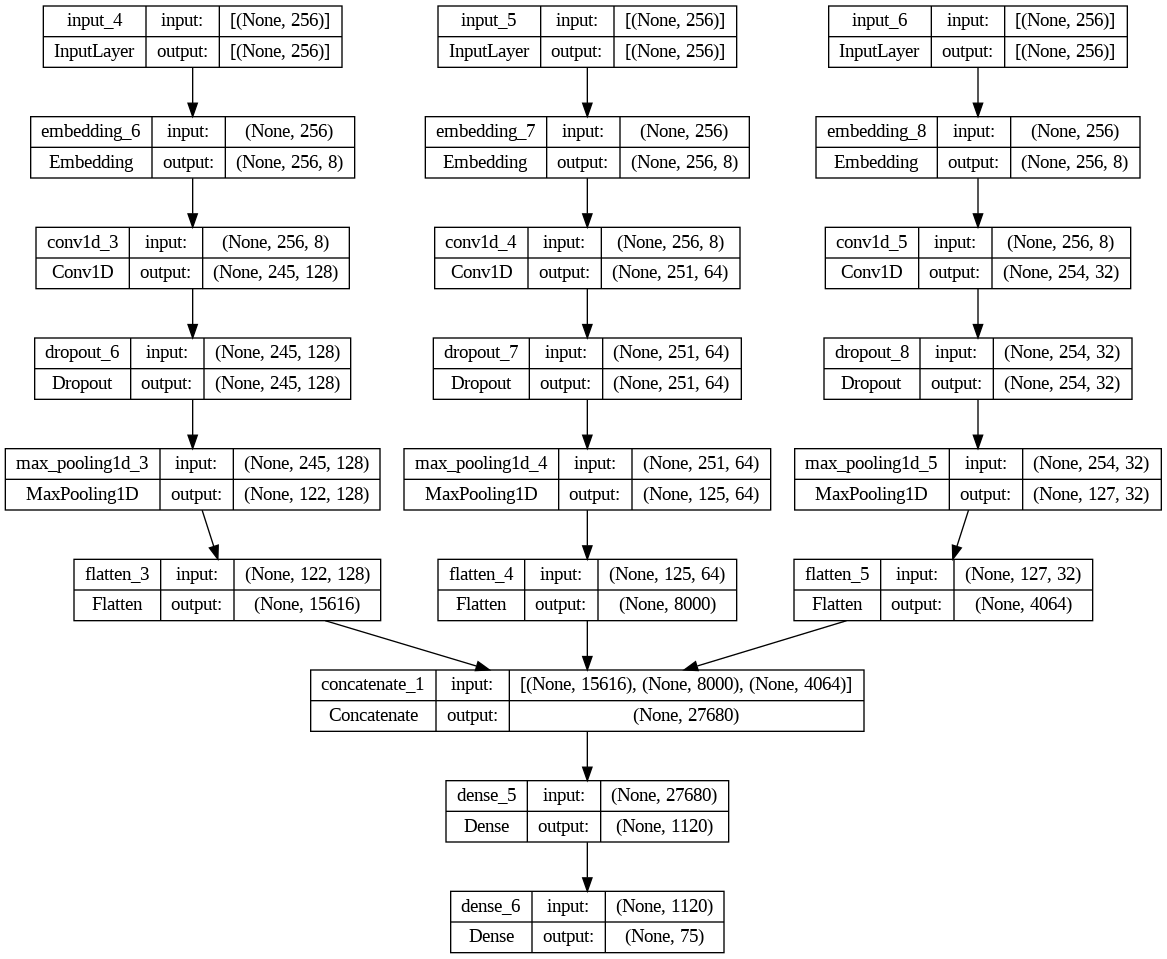

In [ ]:
plot_model(combine_model2, show_shapes = True) #, to_file = '/content/drive/MyDrive/Colab Notebooks/protein_seq_classification/pdb/multichannel.png')

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                                                  mode= 'min',
                                                  restore_best_weights=False,
                                                  patience=3)
metrics_callback_cnn2 = MetricsCallback(validation_data=([X_val_256, X_val_256, X_val_256], y_val_256))

In [ ]:
history_combine_model2 = combine_model2.fit([X_train_256, X_train_256, X_train_256], y_train_256, epochs = 20, batch_size = 128, validation_data=([X_val_256, X_val_256, X_val_256], y_val_256), callbacks = [metrics_callback_cnn2, early_stopping], verbose = 1)


Epoch 1/20


2024-06-20 17:07:38.092982: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


778/778 [==============================] - 95s 120ms/step - loss: 2.1644 - accuracy: 0.4400 - val_loss: 1.6685 - val_accuracy: 0.5621
Epoch 2/20
778/778 [==============================] - 82s 105ms/step - loss: 1.2623 - accuracy: 0.6513 - val_loss: 1.4283 - val_accuracy: 0.6304
Epoch 3/20
778/778 [==============================] - 80s 103ms/step - loss: 0.7885 - accuracy: 0.7672 - val_loss: 1.4230 - val_accuracy: 0.6551
Epoch 4/20
778/778 [==============================] - 81s 103ms/step - loss: 0.5477 - accuracy: 0.8385 - val_loss: 1.4752 - val_accuracy: 0.6649
Epoch 5/20
778/778 [==============================] - 80s 103ms/step - loss: 0.4551 - accuracy: 0.8645 - val_loss: 1.5183 - val_accuracy: 0.6618
Epoch 6/20
778/778 [==============================] - 81s 103ms/step - loss: 0.4104 - accuracy: 0.8753 - val_loss: 1.4687 - val_accuracy: 0.6657


In [ ]:
# Calculate mean and standard deviation for accuracy and loss across epochs
mean_accuracy = np.mean(metrics_callback_cnn2.epoch_accuracy)
std_accuracy = np.std(metrics_callback_cnn2.epoch_accuracy)
mean_loss = np.mean(metrics_callback_cnn2.epoch_loss)
std_loss = np.std(metrics_callback_cnn2.epoch_loss)

mean_val_accuracy = np.mean(metrics_callback_cnn2.epoch_val_accuracy)
std_val_accuracy = np.std(metrics_callback_cnn2.epoch_val_accuracy)
mean_val_loss = np.mean(metrics_callback_cnn2.epoch_val_loss)
std_val_loss = np.std(metrics_callback_cnn2.epoch_val_loss)

mean_f1_weighted = np.mean(metrics_callback_cnn2.epoch_f1_weighted)
std_f1_weighted = np.std(metrics_callback_cnn2.epoch_f1_weighted)
mean_f1_macro = np.mean(metrics_callback_cnn2.epoch_f1_macro)
std_f1_macro = np.std(metrics_callback_cnn2.epoch_f1_macro)

print(f"Training Accuracy (mean ± std): {mean_accuracy:.3f} ± {std_accuracy:.3f}")
print(f"Training Loss (mean ± std): {mean_loss:.3f} ± {std_loss:.3f}")
print(f"Validation Accuracy (mean ± std): {mean_val_accuracy:.3f} ± {std_val_accuracy:.3f}")
print(f"Validation Loss (mean ± std): {mean_val_loss:.3f} ± {std_val_loss:.3f}")
print(f"Validation F1 Score (weighted) (mean ± std): {mean_f1_weighted:.3f} ± {std_f1_weighted:.3f}")
print(f"Validation F1 Score (macro) (mean ± std): {mean_f1_macro:.3f} ± {std_f1_macro:.3f}")

Training Accuracy (mean ± std): 0.739 ± 0.154
Training Loss (mean ± std): 0.938 ± 0.619
Validation Accuracy (mean ± std): 0.640 ± 0.037
Validation Loss (mean ± std): 1.497 ± 0.083
Validation F1 Score (weighted) (mean ± std): 0.632 ± 0.042
Validation F1 Score (macro) (mean ± std): 0.510 ± 0.068


In [ ]:
train_acc = history_combine_model2.history['accuracy']
train_loss = history_combine_model2.history['loss']

val_acc = history_combine_model2.history['val_accuracy']
val_loss = history_combine_model2.history['val_loss']

mean_accuracy = np.mean(train_acc)
std_accuracy = np.std(train_acc)
mean_loss = np.mean(train_loss)
std_loss = np.std(train_loss)
mean_val_accuracy = np.mean(val_acc)
std_val_accuracy = np.std(val_acc)
mean_val_loss = np.mean(val_loss)
std_val_loss = np.std(val_loss)

print(f"Training Accuracy (mean ± std): {mean_accuracy:.3f} ± {std_accuracy:.3f}")
print(f"Training Loss (mean ± std): {mean_loss:.3f} ± {std_loss:.3f}")
print(f"Validation Accuracy (mean ± std): {mean_val_accuracy:.3f} ± {std_val_accuracy:.3f}")
print(f"Validation Loss (mean ± std): {mean_val_loss:.3f} ± {std_val_loss:.3f}")

Training Accuracy (mean ± std): 0.739 ± 0.154
Training Loss (mean ± std): 0.938 ± 0.619
Validation Accuracy (mean ± std): 0.640 ± 0.037
Validation Loss (mean ± std): 1.497 ± 0.083


In [ ]:
# convert the history.history dict to a pandas DataFrame:
# histcnn2_df = pd.DataFrame(history_combine_model2.history)
# histcnn2_df.to_csv('hist_cnn2.csv', index = False)

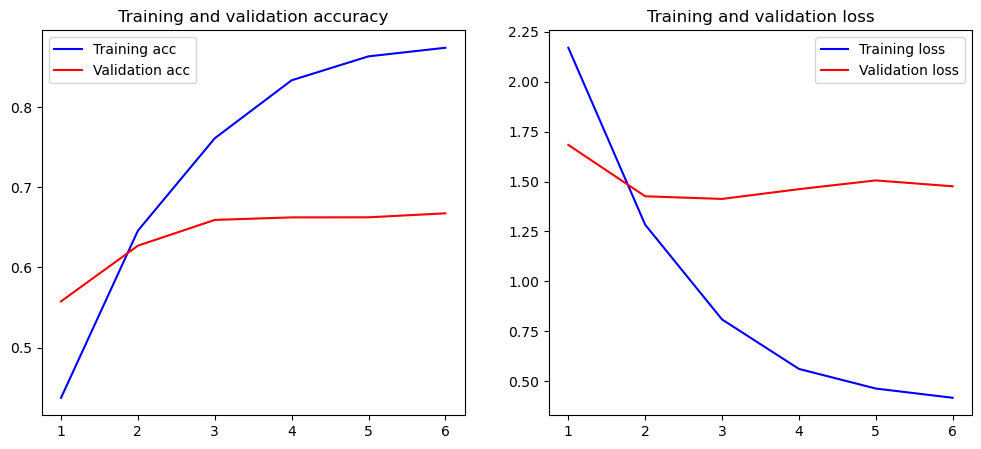

In [ ]:
plot_history(history_combine_model2)

In [ ]:
test_loss2, test_acc2 = combine_model2.evaluate([X_test_256, X_test_256, X_test_256],y_test_256, verbose=1)
print("Test Accuracy: ",test_acc2)
print("Test Loss: ",test_loss2)

865/865 [==============================] - 10s 11ms/step - loss: 1.4774 - accuracy: 0.6690
Test Accuracy:  0.6690413355827332
Test Loss:  1.4774079322814941


In [ ]:
train_pred_combine2 = combine_model2.predict([X_train_256, X_train_256, X_train_256])
test_pred_combine2 = combine_model2.predict([X_test_256, X_test_256, X_test_256])
print("train-acc = " + str(accuracy_score(np.argmax(train_pred_combine2, axis=1), np.argmax(y_train_256, axis=1))))
print("test-acc = " + str(accuracy_score(np.argmax(test_pred_combine2, axis=1), np.argmax(y_test_256, axis=1))))
print("test f1-score = " + str(f1_score(np.argmax(y_test_256, axis=1), np.argmax(test_pred_combine2, axis=1), average = 'weighted')))

865/865 [==============================] - 8s 9ms/step
train-acc = 0.8988417531417321
test-acc = 0.6690413336708495
test f1-score = 0.661219879337307


In [ ]:
print(classification_report(np.argmax(y_test_256, axis=1), np.argmax(test_pred_combine2, axis=1), target_names=lb.classes_))

                          precision    recall  f1-score   support

                allergen       0.86      0.64      0.73        28
    antibiotic hydrolase       0.47      0.31      0.37        26
  antibiotic transferase       0.67      0.30      0.41        20
   antimicrobial protein       0.55      0.43      0.48        37
               apoptosis       0.49      0.50      0.50       107
    biosynthetic protein       0.84      0.43      0.57        83
  biotin-binding protein       0.78      0.75      0.77        24
          blood clotting       0.80      0.36      0.49        67
 calcium-binding protein       0.47      0.29      0.36        24
           cell adhesion       0.63      0.47      0.54       287
              cell cycle       0.73      0.38      0.50       234
           cell invasion       0.64      0.33      0.44        21
               chaperone       0.70      0.63      0.67       268
     contractile protein       0.67      0.71      0.69        79
         

##### Experiment 2a with class weight

In [ ]:
vocab_size = len(tokenizer.word_index)+1
embedding_dim = 8
top_classes = 75
max_length = 256

model_cnn2a = define_model(vocab_size, 8, 3, {1:128, 2:64, 3:32}, {1 : 12, 2 : 6, 3 : 3}, max_length, top_classes)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 input_6 (InputLayer)           [(None, 256)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 256, 8)       168         ['input_4[0][0]']                
                                                                                            

In [ ]:
metrics_callback_cnn2a = MetricsCallback(validation_data=([X_val_256, X_val_256, X_val_256], y_val_256))

history_cnn2a = model_cnn2a.fit([X_train_256, X_train_256, X_train_256], y_train_256, validation_data=([X_val_256, X_val_256, X_val_256], y_val_256), epochs=20, batch_size=128, class_weight = class_weight_dict, callbacks = [metrics_callback_cnn2a, early_stopping], verbose = 1)


Epoch 1/20
778/778 [==============================] - 81s 103ms/step - loss: 3.0652 - accuracy: 0.1863 - val_loss: 2.5934 - val_accuracy: 0.3452
Epoch 2/20
778/778 [==============================] - 71s 92ms/step - loss: 1.4831 - accuracy: 0.4163 - val_loss: 2.2733 - val_accuracy: 0.4268
Epoch 3/20
778/778 [==============================] - 72s 92ms/step - loss: 0.8543 - accuracy: 0.5631 - val_loss: 2.0049 - val_accuracy: 0.4953
Epoch 4/20
778/778 [==============================] - 75s 97ms/step - loss: 0.6313 - accuracy: 0.6557 - val_loss: 1.8226 - val_accuracy: 0.5490
Epoch 5/20
778/778 [==============================] - 73s 93ms/step - loss: 0.5261 - accuracy: 0.7133 - val_loss: 1.8722 - val_accuracy: 0.5666
Epoch 6/20
778/778 [==============================] - 74s 95ms/step - loss: 0.4636 - accuracy: 0.7484 - val_loss: 1.7226 - val_accuracy: 0.5889
Epoch 7/20
778/778 [==============================] - 73s 94ms/step - loss: 0.4287 - accuracy: 0.7751 - val_loss: 1.7476 - val_accuracy

In [ ]:
# Calculate mean and standard deviation for accuracy and loss across epochs
mean_accuracy = np.mean(metrics_callback_cnn2a.epoch_accuracy)
std_accuracy = np.std(metrics_callback_cnn2a.epoch_accuracy)
mean_loss = np.mean(metrics_callback_cnn2a.epoch_loss)
std_loss = np.std(metrics_callback_cnn2a.epoch_loss)

mean_val_accuracy = np.mean(metrics_callback_cnn2a.epoch_val_accuracy)
std_val_accuracy = np.std(metrics_callback_cnn2a.epoch_val_accuracy)
mean_val_loss = np.mean(metrics_callback_cnn2a.epoch_val_loss)
std_val_loss = np.std(metrics_callback_cnn2a.epoch_val_loss)

mean_f1_weighted = np.mean(metrics_callback_cnn2a.epoch_f1_weighted)
std_f1_weighted = np.std(metrics_callback_cnn2a.epoch_f1_weighted)
mean_f1_macro = np.mean(metrics_callback_cnn2a.epoch_f1_macro)
std_f1_macro = np.std(metrics_callback_cnn2a.epoch_f1_macro)

print(f"Training Accuracy (mean ± std): {mean_accuracy:.3f} ± {std_accuracy:.3f}")
print(f"Training Loss (mean ± std): {mean_loss:.3f} ± {std_loss:.3f}")
print(f"Validation Accuracy (mean ± std): {mean_val_accuracy:.3f} ± {std_val_accuracy:.3f}")
print(f"Validation Loss (mean ± std): {mean_val_loss:.3f} ± {std_val_loss:.3f}")
print(f"Validation F1 Score (weighted) (mean ± std): {mean_f1_weighted:.3f} ± {std_f1_weighted:.3f}")
print(f"Validation F1 Score (macro) (mean ± std): {mean_f1_macro:.3f} ± {std_f1_macro:.3f}")

Training Accuracy (mean ± std): 0.736 ± 0.172
Training Loss (mean ± std): 0.606 ± 0.645
Validation Accuracy (mean ± std): 0.571 ± 0.073
Validation Loss (mean ± std): 1.835 ± 0.234
Validation F1 Score (weighted) (mean ± std): 0.581 ± 0.070
Validation F1 Score (macro) (mean ± std): 0.500 ± 0.056


In [ ]:
train_acc = history_cnn2a.history['accuracy']
train_loss = history_cnn2a.history['loss']

val_acc = history_cnn2a.history['val_accuracy']
val_loss = history_cnn2a.history['val_loss']

mean_accuracy = np.mean(train_acc)
std_accuracy = np.std(train_acc)
mean_loss = np.mean(train_loss)
std_loss = np.std(train_loss)
mean_val_accuracy = np.mean(val_acc)
std_val_accuracy = np.std(val_acc)
mean_val_loss = np.mean(val_loss)
std_val_loss = np.std(val_loss)

print(f"Training Accuracy (mean ± std): {mean_accuracy:.3f} ± {std_accuracy:.3f}")
print(f"Training Loss (mean ± std): {mean_loss:.3f} ± {std_loss:.3f}")
print(f"Validation Accuracy (mean ± std): {mean_val_accuracy:.3f} ± {std_val_accuracy:.3f}")
print(f"Validation Loss (mean ± std): {mean_val_loss:.3f} ± {std_val_loss:.3f}")

Training Accuracy (mean ± std): 0.736 ± 0.172
Training Loss (mean ± std): 0.606 ± 0.645
Validation Accuracy (mean ± std): 0.571 ± 0.073
Validation Loss (mean ± std): 1.835 ± 0.234


In [ ]:
# convert the history.history dict to a pandas DataFrame:
# histcnn2a_df = pd.DataFrame(history_cnn2a.history)
# histcnn2a_df.to_csv('hist_cnn2a.csv', index = False)

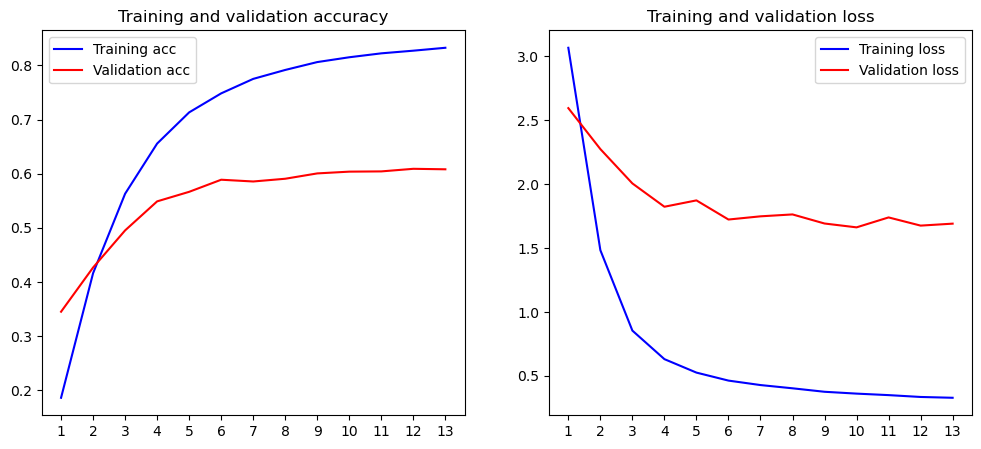

In [ ]:
plot_history(history_cnn2a)

In [ ]:
test_loss2, test_acc2 = model_cnn2a.evaluate([X_test_256, X_test_256, X_test_256],y_test_256, verbose=1)
print("Test Accuracy: ",test_acc2)
print("Test Loss: ",test_loss2)

865/865 [==============================] - 10s 11ms/step - loss: 1.6988 - accuracy: 0.6099
Test Accuracy:  0.6099157333374023
Test Loss:  1.6987587213516235


In [ ]:
train_pred_cnn2a = model_cnn2a.predict([X_train_256, X_train_256, X_train_256])
test_pred_cnn2a = model_cnn2a.predict([X_test_256, X_test_256,X_test_256])
print("train-acc = " + str(accuracy_score(np.argmax(train_pred_cnn2a, axis=1), np.argmax(y_train_256, axis=1))))
print("test-acc = " + str(accuracy_score(np.argmax(test_pred_cnn2a, axis=1), np.argmax(y_test_256, axis=1))))
print("test f1-score = " + str(f1_score(np.argmax(y_test_256, axis=1), np.argmax(test_pred_cnn2a, axis=1), average = 'weighted')))

865/865 [==============================] - 8s 9ms/step
train-acc = 0.8479009914914563
test-acc = 0.6099157415108668
test f1-score = 0.6193543613690959


In [ ]:
print(classification_report(np.argmax(y_test_256, axis=1), np.argmax(test_pred_cnn2a, axis=1), target_names=lb.classes_))

                          precision    recall  f1-score   support

                allergen       0.87      0.71      0.78        28
    antibiotic hydrolase       0.06      0.73      0.11        26
  antibiotic transferase       0.15      0.45      0.22        20
   antimicrobial protein       0.49      0.59      0.54        37
               apoptosis       0.44      0.54      0.49       107
    biosynthetic protein       0.55      0.53      0.54        83
  biotin-binding protein       0.76      0.79      0.78        24
          blood clotting       0.30      0.70      0.42        67
 calcium-binding protein       0.27      0.71      0.39        24
           cell adhesion       0.53      0.49      0.51       287
              cell cycle       0.44      0.52      0.48       234
           cell invasion       0.70      0.33      0.45        21
               chaperone       0.72      0.63      0.67       268
     contractile protein       0.52      0.65      0.57        79
         

##### EXPERIMENT 3

In [ ]:
vocab_size = len(tokenizer.word_index)+1
embedding_dim = 8
top_classes = 75
max_length = 100

combine_model3 = define_model(vocab_size, 8, 3, {1:128, 2:64, 3:32}, {1 : 12, 2 : 6, 3 : 3}, max_length, top_classes)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 input_9 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 embedding_9 (Embedding)     (None, 100, 8)               168       ['input_7[0][0]']             
                                                                                            

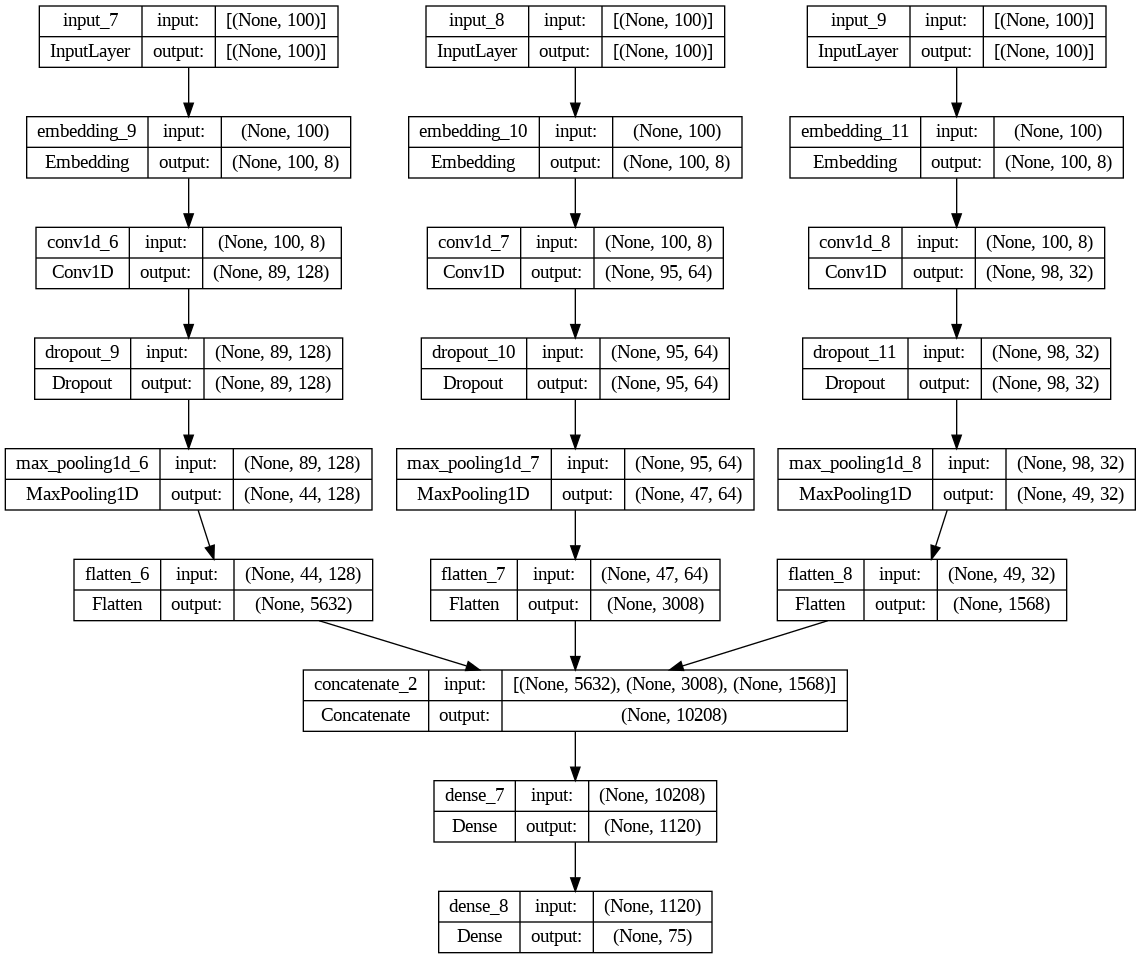

In [ ]:
plot_model(combine_model3, show_shapes = True) #, to_file = '/content/drive/MyDrive/Colab Notebooks/protein_seq_classification/pdb/multichannel.png')

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss',
                                                  mode= 'min',
                                                  restore_best_weights=False,
                                                  patience=3)

In [ ]:
history_combine_model3 = combine_model3.fit([X_train_100, X_train_100, X_train_100], y_train_100, epochs = 20, batch_size = 128, validation_data=([X_val_100, X_val_100, X_val_100], y_val_100), callbacks = early_stopping, verbose = 1) #


Epoch 1/20
778/778 [==============================] - 29s 36ms/step - loss: 2.4009 - accuracy: 0.3854 - val_loss: 1.9496 - val_accuracy: 0.4902
Epoch 2/20
778/778 [==============================] - 28s 36ms/step - loss: 1.6205 - accuracy: 0.5640 - val_loss: 1.6395 - val_accuracy: 0.5769
Epoch 3/20
778/778 [==============================] - 28s 35ms/step - loss: 1.1760 - accuracy: 0.6679 - val_loss: 1.5198 - val_accuracy: 0.6187
Epoch 4/20
778/778 [==============================] - 27s 35ms/step - loss: 0.8560 - accuracy: 0.7412 - val_loss: 1.5018 - val_accuracy: 0.6417
Epoch 5/20
778/778 [==============================] - 28s 36ms/step - loss: 0.6345 - accuracy: 0.8055 - val_loss: 1.5329 - val_accuracy: 0.6510
Epoch 6/20
778/778 [==============================] - 27s 35ms/step - loss: 0.5125 - accuracy: 0.8418 - val_loss: 1.5813 - val_accuracy: 0.6562
Epoch 7/20
778/778 [==============================] - 28s 36ms/step - loss: 0.4581 - accuracy: 0.8587 - val_loss: 1.5863 - val_accuracy:

In [ ]:
# convert the history.history dict to a pandas DataFrame:
histcnn3_df = pd.DataFrame(history_combine_model3.history)
histcnn3_df.to_csv('hist_cnn3.csv', index = False)

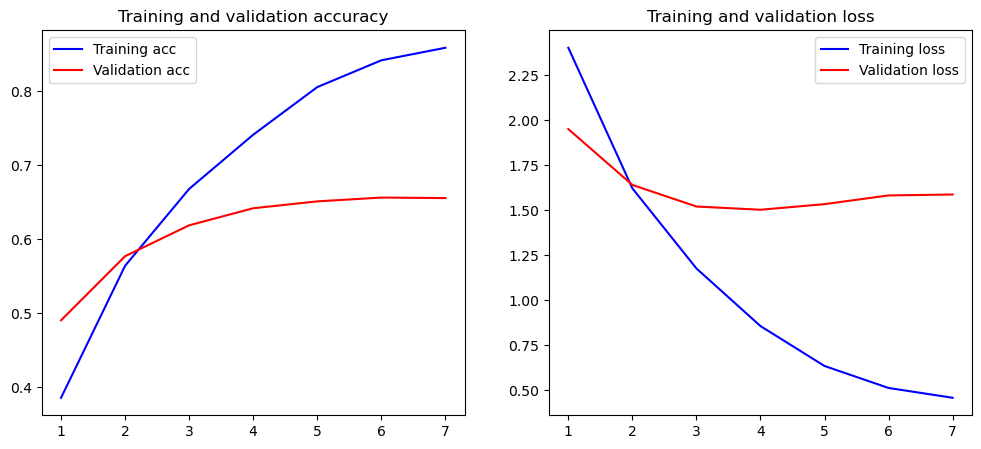

In [ ]:
plot_history(history_combine_model3)

In [ ]:
test_loss3, test_acc3 = combine_model3.evaluate([X_test_100, X_test_100, X_test_100],y_test_100, verbose=1)
print("Test Accuracy: ",test_acc3)
print("Test Loss: ",test_loss3)

865/865 [==============================] - 8s 10ms/step - loss: 1.5767 - accuracy: 0.6546
Test Accuracy:  0.6546486616134644
Test Loss:  1.5766571760177612


In [ ]:
train_pred_combine3 = combine_model3.predict([X_train_100, X_train_100, X_train_100])
test_pred_combine3 = combine_model3.predict([X_test_100, X_test_100, X_test_100])
print("train-acc = " + str(accuracy_score(np.argmax(train_pred_combine3, axis=1), np.argmax(y_train_100, axis=1))))
print("test-acc = " + str(accuracy_score(np.argmax(test_pred_combine3, axis=1), np.argmax(y_test_100, axis=1))))
print("test f1-score = " + str(f1_score(np.argmax(y_test_100, axis=1), np.argmax(test_pred_combine3, axis=1), average = 'weighted')))

865/865 [==============================] - 5s 6ms/step
train-acc = 0.8937587270334616
test-acc = 0.6546486818790005
test f1-score = 0.6493387461524153


In [ ]:
print(classification_report(np.argmax(y_test_100, axis=1), np.argmax(test_pred_combine3, axis=1), target_names=lb.classes_))

                          precision    recall  f1-score   support

                allergen       0.82      0.64      0.72        28
    antibiotic hydrolase       0.50      0.42      0.46        26
  antibiotic transferase       0.24      0.45      0.31        20
   antimicrobial protein       0.74      0.54      0.62        37
               apoptosis       0.50      0.54      0.52       107
    biosynthetic protein       0.76      0.47      0.58        83
  biotin-binding protein       0.81      0.71      0.76        24
          blood clotting       0.85      0.43      0.57        67
 calcium-binding protein       0.40      0.33      0.36        24
           cell adhesion       0.60      0.49      0.54       287
              cell cycle       0.36      0.52      0.42       234
           cell invasion       0.64      0.33      0.44        21
               chaperone       0.73      0.59      0.65       268
     contractile protein       0.73      0.51      0.60        79
         

In [ ]:
def plot_compare_history(history1, history2, history3):
  val_acc1 = history1.history['val_accuracy']
  val_acc2 = history2.history['val_accuracy'][:-1]
  val_acc3 = history3.history['val_accuracy'][:-2]
  val_loss1 = history1.history['val_loss']
  val_loss2 = history2.history['val_loss'][:-1]
  val_loss3 = history3.history['val_loss'][:-2]
  x = range(1, len(val_acc1) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, val_acc1, 'b', label='val-acc 512 ')
  plt.plot(x, val_acc2, 'r', label='val-acc 256')
  plt.plot(x, val_acc3, 'g', label='val-acc 100')
  plt.title('Validation accuracy for different sequence length')
  plt.legend()
  plt.xticks(np.arange(1, len(val_acc1) + 1, step=1))

  plt.subplot(1, 2, 2)
  plt.plot(x, val_loss1, 'b', label='val-loss 512')
  plt.plot(x, val_loss2, 'r', label='val-loss 256')
  plt.plot(x, val_loss3, 'g', label='val-loss 100')
  plt.title('Validation loss for different sequence length')
  plt.legend()
  plt.xticks(np.arange(1, len(val_acc1) + 1, step=1))

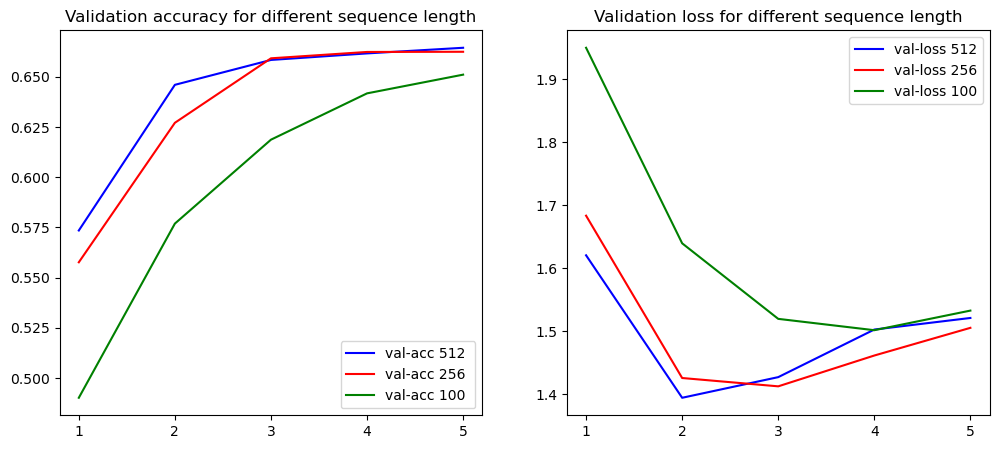

In [ ]:
plot_compare_history(history_combine_model1, history_combine_model2, history_combine_model3)

##### Experiment 3a with class weight

In [ ]:
vocab_size = len(tokenizer.word_index)+1
embedding_dim = 8
top_classes = 75
max_length = 100

model_cnn3a = define_model(vocab_size, 8, 3, {1:128, 2:64, 3:32}, {1 : 12, 2 : 6, 3 : 3}, max_length, top_classes)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_17 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 input_18 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 embedding_15 (Embedding)       (None, 100, 8)       168         ['input_16[0][0]']               
                                                                                            

In [ ]:
history_cnn3a = model_cnn3a.fit([X_train_100, X_train_100, X_train_100], y_train_100, validation_data=([X_val_100, X_val_100, X_val_100], y_val_100), epochs=20, batch_size=128, class_weight = class_weight_dict, callbacks = early_stopping)


Epoch 1/20
778/778 [==============================] - 29s 37ms/step - loss: 3.2669 - accuracy: 0.1417 - val_loss: 3.0063 - val_accuracy: 0.2493
Epoch 2/20
778/778 [==============================] - 28s 36ms/step - loss: 1.8524 - accuracy: 0.3092 - val_loss: 2.6567 - val_accuracy: 0.3271
Epoch 3/20
778/778 [==============================] - 28s 36ms/step - loss: 1.1601 - accuracy: 0.4253 - val_loss: 2.3391 - val_accuracy: 0.3930
Epoch 4/20
778/778 [==============================] - 28s 36ms/step - loss: 0.8459 - accuracy: 0.5153 - val_loss: 2.1266 - val_accuracy: 0.4540
Epoch 5/20
778/778 [==============================] - 28s 36ms/step - loss: 0.6826 - accuracy: 0.5829 - val_loss: 2.1395 - val_accuracy: 0.4760
Epoch 6/20
778/778 [==============================] - 28s 36ms/step - loss: 0.5906 - accuracy: 0.6335 - val_loss: 1.9791 - val_accuracy: 0.5178
Epoch 7/20
778/778 [==============================] - 28s 36ms/step - loss: 0.5214 - accuracy: 0.6759 - val_loss: 2.1638 - val_accuracy:

In [ ]:
# convert the history.history dict to a pandas DataFrame:
histcnn3a_df = pd.DataFrame(history_cnn3a.history)
histcnn3a_df.to_csv('hist_cnn3a.csv', index = False)

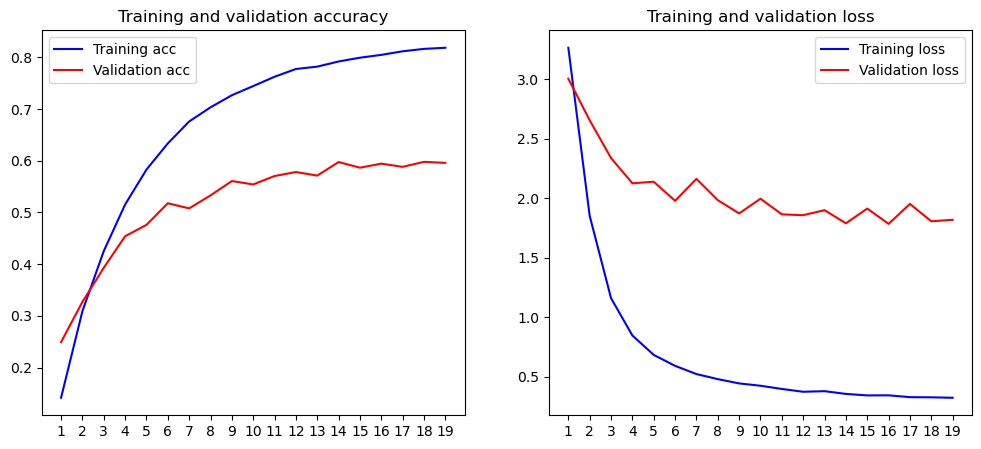

In [ ]:
plot_history(history_cnn3a)

In [ ]:
test_loss3, test_acc3 = model_cnn3a.evaluate([X_test_100, X_test_100, X_test_100],y_test_100, verbose=1)
print("Test Accuracy: ",test_acc3)
print("Test Loss: ",test_loss3)

865/865 [==============================] - 9s 10ms/step - loss: 1.7805 - accuracy: 0.6045
Test Accuracy:  0.6044552326202393
Test Loss:  1.780497670173645


In [ ]:
train_pred_cnn3a = model_cnn3a.predict([X_train_100, X_train_100, X_train_100])
test_pred_cnn3a = model_cnn3a.predict([X_test_100, X_test_100, X_test_100])
print("train-acc = " + str(accuracy_score(np.argmax(train_pred_cnn3a, axis=1), np.argmax(y_train_100, axis=1))))
print("test-acc = " + str(accuracy_score(np.argmax(test_pred_cnn3a, axis=1), np.argmax(y_test_100, axis=1))))
print("test f1-score = " + str(f1_score(np.argmax(y_test_100, axis=1), np.argmax(test_pred_cnn3a, axis=1), average = 'weighted')))

865/865 [==============================] - 5s 6ms/step
train-acc = 0.8416727776829036
test-acc = 0.6044552128159694
test f1-score = 0.6134231885084167


In [ ]:
print(classification_report(np.argmax(y_test_100, axis=1), np.argmax(test_pred_cnn3a, axis=1), target_names=lb.classes_))

                          precision    recall  f1-score   support

                allergen       0.61      0.71      0.66        28
    antibiotic hydrolase       0.08      0.65      0.15        26
  antibiotic transferase       0.13      0.45      0.20        20
   antimicrobial protein       0.56      0.59      0.58        37
               apoptosis       0.46      0.53      0.50       107
    biosynthetic protein       0.40      0.53      0.46        83
  biotin-binding protein       0.76      0.79      0.78        24
          blood clotting       0.33      0.67      0.45        67
 calcium-binding protein       0.26      0.46      0.33        24
           cell adhesion       0.54      0.55      0.54       287
              cell cycle       0.49      0.50      0.49       234
           cell invasion       0.64      0.33      0.44        21
               chaperone       0.60      0.62      0.61       268
     contractile protein       0.65      0.76      0.70        79
         

In [ ]:
def plot_compare_history1(history1, history2, history3):
  val_acc1 = history1.history['val_accuracy']
  val_acc2 = history2.history['val_accuracy'][:-1]
  val_acc3 = history3.history['val_accuracy'][:-7]
  val_loss1 = history1.history['val_loss']
  val_loss2 = history2.history['val_loss'][:-1]
  val_loss3 = history3.history['val_loss'][:-7]
  x = range(1, len(val_acc3) + 1)

  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)
  plt.plot(x, val_acc1, 'b', label='val-acc 512 ')
  plt.plot(x, val_acc2, 'r', label='val-acc 256')
  plt.plot(x, val_acc3, 'g', label='val-acc 100')
  plt.title('Validation accuracy for different sequence length')
  plt.xlabel('epochs')
  plt.ylabel('accuracy')
  plt.legend()
  plt.xticks(np.arange(1, len(val_acc1) + 1, step=1))

  plt.subplot(1, 2, 2)
  plt.plot(x, val_loss1, 'b', label='val-loss 512')
  plt.plot(x, val_loss2, 'r', label='val-loss 256')
  plt.plot(x, val_loss3, 'g', label='val-loss 100')
  plt.title('Validation loss for different sequence length')
  plt.xlabel('epochs')
  plt.ylabel('loss')
  plt.legend()
  plt.xticks(np.arange(1, len(val_acc1) + 1, step=1))

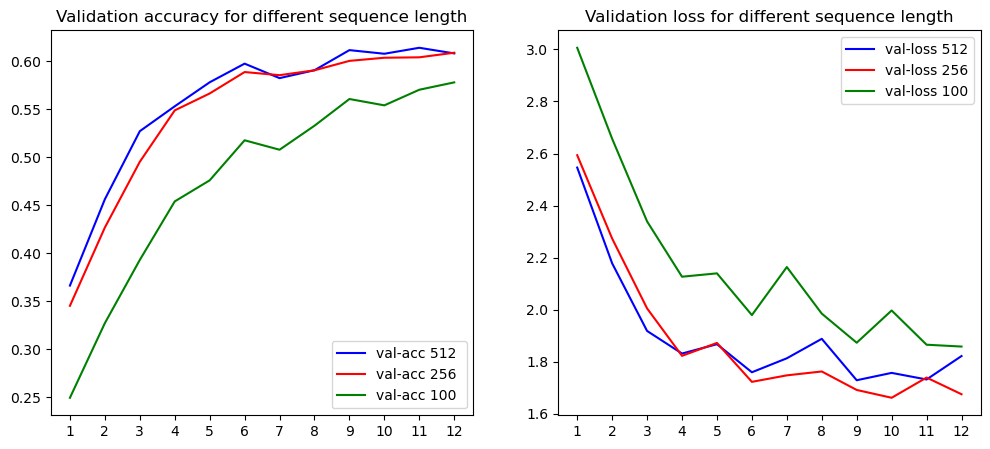

In [ ]:
plot_compare_history1(history_cnn1a, history_cnn2a, history_cnn3a)

### Comparing Models

In [ ]:
cnn_acc = [0.65, 0.67, 0.66]
cnn_macro_f1 = [0.54, 0.55, 0.55]
cnn_weighted_f1 = [0.65, 0.66, 0.66]
lstm_acc = [0.51, 0.49, 0.41]
lstm_macro_f1 = [0.32, 0.28, 0.16]
lstm_weighted_f1 = [0.48, 0.46, 0.36]
length = [100, 256, 512]


In [ ]:
dl_df1 = pd.DataFrame({'cnn accuracy': cnn_acc, 'cnn macro f1': cnn_macro_f1, 'cnn weighted f1': cnn_weighted_f1, 'lstm accuracy': lstm_acc, 'lstm macro f1': lstm_macro_f1, 'lstm weighted f1': lstm_weighted_f1}, index=length)

dl_df1

,cnn accuracy,cnn macro f1,cnn weighted f1,lstm accuracy,lstm macro f1,lstm weighted f1
100,0.65,0.54,0.65,0.51,0.32,0.48
256,0.67,0.55,0.66,0.49,0.28,0.46
512,0.66,0.55,0.66,0.41,0.16,0.36


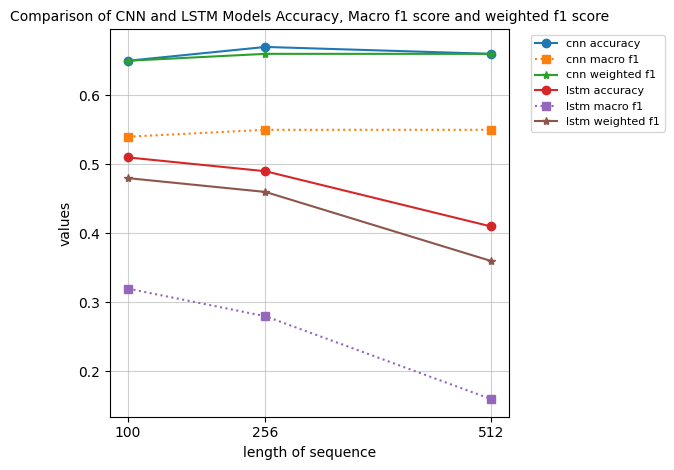

In [ ]:
# plt.figure(figsize = (10,6))
ax = dl_df1.plot(kind = 'line', style=['o-','s:', '*-', 'o-','s:', '*-'])
ax.legend(
    bbox_to_anchor=(1.04, 1),
    prop={'size': 8}
)
plt.grid(alpha = 0.6)
plt.xticks([100, 256, 512])
plt.title("Comparison of CNN and LSTM Models Accuracy, Macro f1 score and weighted f1 score",fontsize=10)
plt.xlabel('length of sequence')
plt.ylabel('values')
plt.tight_layout()
# plt.savefig('pics/pdb_comparison_cnnlstm_model.jpg', dpi = 300, bbox_inches='tight')
plt.show()

In [ ]:
cnn_acc = [0.65, 0.67, 0.66]
cnn_macro_f1 = [0.50, 0.55, 0.55]
cnn_weighted_f1 = [0.64, 0.66, 0.66]
lstm_acc = [0.51, 0.49, 0.41]
lstm_macro_f1 = [0.32, 0.28, 0.16]
lstm_weighted_f1 = [0.48, 0.46, 0.36]
length = [100, 256, 512]
cnn_acc_cw = [0.60, 0.61, 0.62]
cnn_macro_f1_cw = [0.52, 0.53, 0.53]
cnn_weighted_f1_cw = [0.61, 0.62, 0.63]

In [ ]:
dl_df2 = pd.DataFrame({'cnn accuracy': cnn_acc, 'cnn macro f1': cnn_macro_f1, 'cnn weighted f1': cnn_weighted_f1,
                       'cnn acc with cw': cnn_acc_cw, 'cnn macro f1 with cw': cnn_macro_f1_cw, 'cnn weighted f1 with cw': cnn_weighted_f1_cw,
                       'lstm accuracy': lstm_acc, 'lstm macro f1': lstm_macro_f1, 'lstm weighted f1': lstm_weighted_f1}, index=length)

dl_df2

,cnn accuracy,cnn macro f1,cnn weighted f1,cnn acc with cw,cnn macro f1 with cw,cnn weighted f1 with cw,lstm accuracy,lstm macro f1,lstm weighted f1
100,0.65,0.50,0.64,0.60,0.52,0.61,0.51,0.32,0.48
256,0.67,0.55,0.66,0.61,0.53,0.62,0.49,0.28,0.46
512,0.66,0.55,0.66,0.62,0.53,0.63,0.41,0.16,0.36


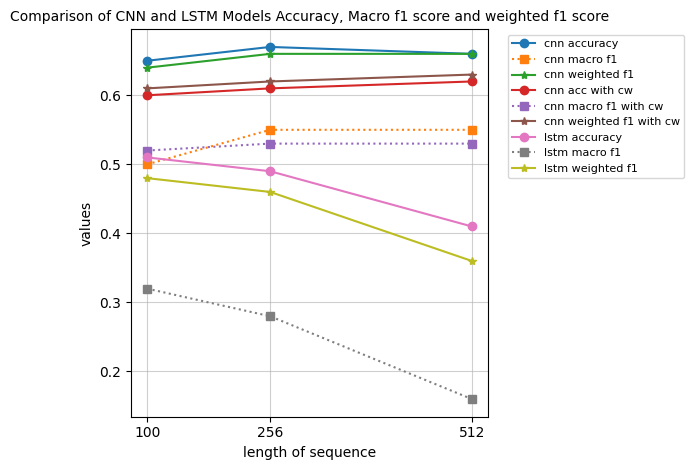

In [ ]:
# plt.figure(figsize = (10,6))
ax = dl_df2.plot(kind = 'line', style=['o-','s:', '*-', 'o-','s:', '*-', 'o-','s:', '*-'])
ax.legend(
    bbox_to_anchor=(1.04, 1),
    prop={'size': 8}
)
plt.grid(alpha = 0.6)
plt.xticks([100, 256, 512])
plt.title("Comparison of CNN and LSTM Models Accuracy, Macro f1 score and weighted f1 score",fontsize=10)
plt.xlabel('length of sequence')
plt.ylabel('values')
plt.tight_layout()
# plt.savefig('pdb_comparison_cnnlstm_model.jpg', dpi = 300, bbox_inches='tight')
plt.show()